### Import Libraries

In [138]:
import torch
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from matplotlib.ticker import MaxNLocator


In [4]:
sns.set_theme(style="whitegrid", rc={'font.family': 'sans-serif', 'font.sans-serif': 'Helvetica'})

### Correlation between cost model and gpt4 score

In [ ]:
df = pd.read_csv('/home/cjh/Academics/Alignment-Low-Rank-Analysis/results/gpt4_judge/top0_guided_by_Llama-2-7b-hf_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_Llama-2-7b-hf_base_vs_dpo_on_beavertails_base_completion_table.csv', usecols=['cost_scores', 'gpt4_scores'])

In [ ]:
# Creating a linear model plot
g = sns.lmplot(x="cost_scores", y="gpt4_scores", data=df, aspect=1.3)

# Setting axis labels with font size and using the updated font
g.set_axis_labels(x_var='Cost Score', y_var='GPT4 Score', fontsize=18, fontweight=500)

# Setting tick labels with font size and ensuring the font weight applies
g.set_yticklabels(fontsize=18)
g.set_xticklabels(fontsize=18)

# Adjusting the limits of the plot
g.set(xlim=(-25,45), ylim=(-1,12))

# Saving the plot to a PDF file with the specified DPI and tight bounding box
plt.savefig('./fig/cost_corr.pdf', dpi=600, format='pdf', bbox_inches="tight")


### Neuron correlation between different models

In [2]:
# sns.set_theme(style="white", palette='Dark2')
hue_order = ['Llama2', 'Gemma', 'Mistral']
# Define a custom color palette for the desired hue order
custom_palette = sns.color_palette("YlGnBu", len(hue_order))
# Map the custom palette to the desired hue order
hue_colors = dict(zip(hue_order, custom_palette))

In [3]:
def corr(indexes: list, filenames: list[str], topk: int=None):
    if not topk:
        topk = len(indexes[0])
    common_set = set(indexes[0][:topk])
    for index in indexes[1:]:
        common_set.intersection_update(set(index[:topk]))
    print(len(common_set)/topk)
    df = pd.DataFrame({f'{filenames[i]}': [idx for idx in indexes[i] if idx in common_set] for i in range(len(indexes))})
    ref = df.iloc[:, 0].to_list()
    df_rank = df.map(lambda x: ref.index(x))
    return common_set, df_rank

def pair_wise_corr(indexes: list, filenames: list[str], topk: int=None):
    n = len(indexes)
    overlap, spearman = np.zeros((n, n)), np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            cs, rank = corr([indexes[i], indexes[j]], [filenames[i], filenames[j]], topk)
            overlap[i, j] = len(cs) / topk
            spearman[i, j] = rank.corr('spearman').iloc[0, 1]
    return overlap, spearman

In [6]:
data_sets = [
    # 'beavertails',
    'hh_harmless',
    # 'self_instruct',
    # 'hh_helpful'
]
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_{}_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
models = [
    'hh_harmless', 
    'rewardbench_safety',
    'hh_helpful',
    'shp',
    'H4_stack_exchange',
    'rewardbench_reasoning',
    'IEFeedback'
]
llms = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
overlaps, spearmans = [], []
index_lists = []
for model in models:
    for neuron_index in neuron_indexes:
        index_path = [f'/data1/cjh/Alignment/hooked_llama/neuron_activation/{llms[2]}_sharegpt_ia3_ff_1_{model}_dpo_ia3_ff_{neuron_index.format(data_set)}.pt' for data_set in data_sets]
        for path in index_path:
            _, index, *_ = torch.load(path)
            index_list = index.tolist()
            index_lists.append([(a, b) for a, b in index_list])
            
overlap, spearman = pair_wise_corr(index_lists, models, topk=20000)
overlaps.append(overlap)
spearmans.append(spearman)

0.71625
0.82495
0.78965
0.7448
0.6255
0.69565
0.69535
0.7016
0.67985
0.7082
0.7432
0.79125
0.7547
0.6246
0.7015
0.7571
0.6329
0.71995
0.6379
0.73935
0.69205


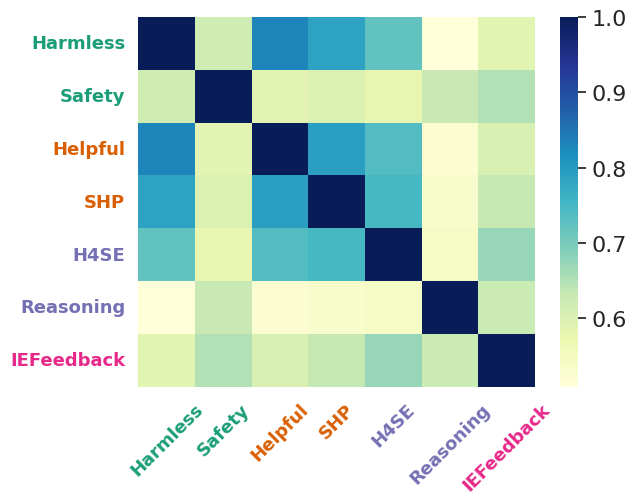

In [7]:
df = pd.DataFrame(
    (spearmans[0] + spearmans[0].T + np.eye(len(index_lists))),
    index=models,
    columns=models
)
labels = ['Harmless', 'Safety', 'Helpful', 'SHP', 'H4SE', 'Reasoning', 'IEFeedback']
palette = sns.color_palette()
colors = [palette[0]] * 2 + [palette[1]] * 2 + [palette[2]] * 2 + [palette[3]] # Colors for each label
mask = np.eye(len(labels), dtype=bool)
# plot a heatmap with annotation
g = sns.heatmap(df, annot=False, mask=None, annot_kws={"size": 13}, cbar=True, cmap="YlGnBu")
g.set_xticklabels(labels=labels, rotation=45, fontsize=13)
g.set_yticklabels(labels=labels, rotation=0, fontsize=13)
# Setting colored labels for x-axis
for tick_label, color in zip(g.get_xticklabels(), colors):
    tick_label.set_fontweight(700)
    tick_label.set_color(color)

# Setting colored labels for y-axis
for tick_label, color in zip(g.get_yticklabels(), colors):
    tick_label.set_fontweight(700)
    tick_label.set_color(color)

cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Set the color bar font size to 15
# Saving the plot to a PDF file with the specified DPI and tight bounding box
plt.savefig('./fig/models_corr_gemma.pdf', dpi=300, format='pdf', bbox_inches="tight")

### Distribution of change scores

In [129]:
dists = {}
for model in ['Llama-2-7b-hf', 'gemma-7b', 'Mistral-7B-v0.1']:
    dist, *_ = torch.load(f'/data1/cjh/Alignment/hooked_llama/neuron_activation/{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_sft_vs_dpo_on_hh_harmless_sft_completion.pt')
    dists[model] = dist

In [134]:
topk_dists = {}
for k, v in dists.items():
    top20000 = v.flatten().topk(20000).values
    topk_dists[k] = top20000

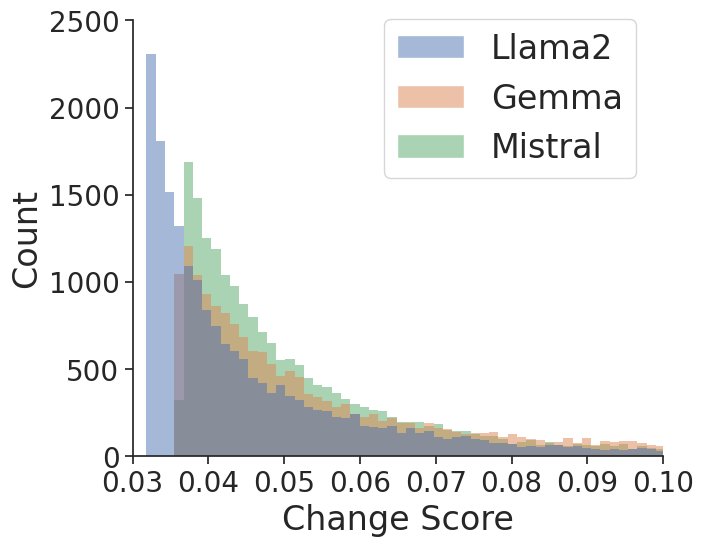

In [137]:
fontsize = 24
g = sns.displot(topk_dists, aspect=1.3)

# Setting tick labels with font size and ensuring the font weight applies
g.set(xlim=(0.0317, 0.1), ylim=(0, 2500))
g.set_yticklabels(fontsize=fontsize-4, fontweight=500)
g.set_xticklabels(fontsize=fontsize-4, fontweight=500)
# g.set(xlim=(0.0317, 0.1), ylim=(0, 2600))
g.set_axis_labels(x_var='Change Score', y_var='Count', fontsize=fontsize, fontweight=500)
new_labels = ['Llama2', 'Gemma', 'Mistral']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

sns.move_legend(g, 'upper left', bbox_to_anchor=(0.4,1), fontsize=fontsize, frameon=True)
custom_font = font_manager.FontProperties(style='normal', weight=700, size=fontsize)
g._legend.set_title(None)
g._legend.get_title().set_fontproperties(custom_font)
# # Saving the plot to a PDF file with the specified DPI and tight bounding box
plt.savefig('./fig/change_score_hist.pdf', dpi=300, format='pdf', bbox_inches="tight")

In [ ]:
for model in ['Llama-2-7b-hf', 'gemma-7b', 'Mistral-7B-v0.1']:
    print(skew(topk_dists[model]))

### Neuron distribution in layers

In [121]:
def create_df(indexes: list, names: list, n_groups: int, topk: int):
    df_dict = {'layers': [], 'ranks': [], 'names': []}
    for index, name in zip(indexes, names):
        df_dict['ranks'] += (np.arange(topk) // (topk // n_groups)).tolist()
        df_dict['layers'] += [layer.item() for layer, neuron in index[:topk]]
        df_dict['names'] += [name] * topk
    return pd.DataFrame(data=df_dict)

def normalize_layers(values):
    # print(values['names'])
    layers = {'Llama-2-7b-hf': 32, 'Mistral-7B-v0.1': 32, 'gemma-7b': 28}
    values['layers'] = float(values['layers']) / (layers[values['names']] - 2)
    return values

In [122]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
indexes = []
for model in models:
    _, index, *_ = torch.load(f'/data1/cjh/Alignment/hooked_llama/neuron_activation/{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_sft_vs_dpo_on_hh_harmless_sft_completion.pt')
    indexes.append(index)
df = create_df(indexes, models, 4, 20000)
df = df.apply(normalize_layers, axis=1)

/tmp/ipykernel_295664/1758894897.py:8: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  g = sns.violinplot(x='ranks', y='layers', hue='names', data=df, palette=sns.color_palette('tab10'))
/tmp/ipykernel_295664/1758894897.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(['5000', '10000', '15000', '20000'], fontsize=24, fontweight=500)
/tmp/ipykernel_295664/1758894897.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), fontsize=24, fontweight=500)


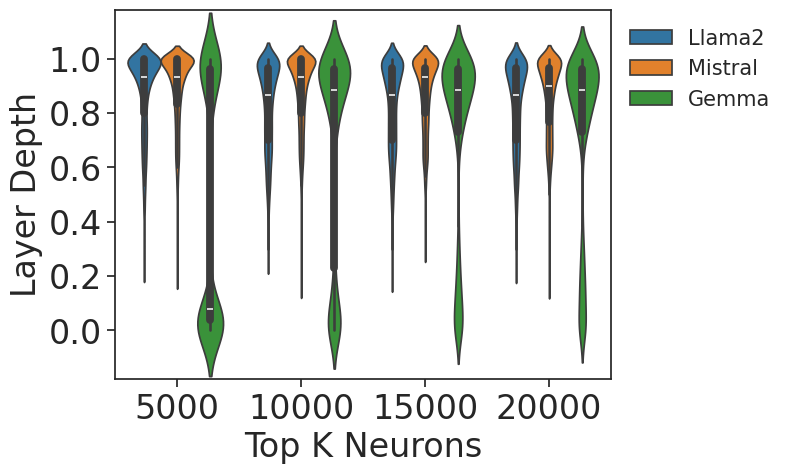

In [128]:
new_labels = ['Llama2', 'Mistral', 'Gemma']
hue_order = ['Llama-2-7b-hf', 'gemma-7b', 'Mistral-7B-v0.1']
# Define a custom color palette for the desired hue order
# custom_palette = sns.color_palette("Dark2", len(hue_order))
# Map the custom palette to the desired hue order
# hue_colors = dict(zip(hue_order, custom_palette))

g = sns.violinplot(x='ranks', y='layers', hue='names', data=df, palette=sns.color_palette('tab10'))
g.set_xlabel('Top K Neurons', fontsize=24, fontweight=500)
g.set_ylabel('Layer Depth', fontsize=24, fontweight=500)
g.set_xticklabels(['5000', '10000', '15000', '20000'], fontsize=24, fontweight=500)
g.set_ylim(-0.18, 1.18)
g.set_yticklabels(g.get_yticklabels(), fontsize=24, fontweight=500)

for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
custom_font = font_manager.FontProperties(style='normal', weight=700, size=15)
g.legend_.set_title(None)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1,1), fontsize=15, frameon=False)

plt.savefig('./fig/layer_distribution.pdf', dpi=300, format='pdf', bbox_inches="tight")

### Neuron correlation between different datasets

In [ ]:
data_sets = [
    'beavertails',
    'hh_harmless',
    'jailbreak_llms',
    'hh_helpful',
    'lima',
    'rewardbench_reasoning',
]
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_{}_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
models = [
    'hh_harmless', 
]
overlaps, spearmans = [], []
index_lists = []
for model in models:
    for neuron_index in neuron_indexes:
        index_path = [f'/data1/cjh/Alignment/hooked_llama/neuron_activation/Llama-2-7b-hf_sharegpt_ia3_ff_1_{model}_dpo_ia3_ff_{neuron_index.format(data_set)}.pt' for data_set in data_sets]
        for path in index_path:
            _, index, *_ = torch.load(path)
            index_list = index.tolist()
            index_lists.append([(a, b) for a, b in index_list])
            
overlap, spearman = pair_wise_corr(index_lists, data_sets, topk=20000)
overlaps.append(overlap)
spearmans.append(spearman)

In [ ]:
df = pd.DataFrame(
    overlaps[0] + overlaps[0].T + np.eye(len(index_lists)),
    index=data_sets,
    columns=data_sets
)
labels = ['Beavertails', 'HH-Harmless', 'JailBreakLLMs', 'HH-Helpful', 'LIMA', 'Reasoning']
palette = sns.color_palette("rocket")
colors = [palette[1]] * 3 + [palette[3]] * 2 + [palette[5]]  # Colors for each label
# plot a heatmap with annotation
g = sns.heatmap(df, annot=True, annot_kws={"size": 13}, cbar=False, cmap='rocket')
g.set_xticklabels(labels=labels, rotation=45, fontsize=13)
g.set_yticklabels(labels=labels, rotation=0, fontsize=13)
# Setting colored labels for x-axis
for tick_label, color in zip(g.get_xticklabels(), colors):
    tick_label.set_color(color)

# Setting colored labels for y-axis
for tick_label, color in zip(g.get_yticklabels(), colors):
    tick_label.set_color(color)
# g.set_aspect(1)
# Saving the plot to a PDF file with the specified DPI and tight bounding box
plt.savefig('./fig/datasets_corr.pdf', dpi=600, format='pdf', bbox_inches="tight")

### Patch Line Plot

In [139]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
pefts = ['', '_sharegpt_ia3_ff_1']
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
data_sets = [
    # 'beavertails',
    'hh_harmless',
    # 'self_instruct',
    # 'hh_helpful'
]
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_hh_harmless_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
for model in models:
    for peft in pefts:
        for index in neuron_indexes:
            file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_{index}.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Neuron Type': 'Safety Neurons'
            })
            dfs.append(new_df)
            file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_{index}_random_neurons.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Neuron Type': 'Random Neurons'
            })
            dfs.append(new_df)

df = pd.concat(dfs)

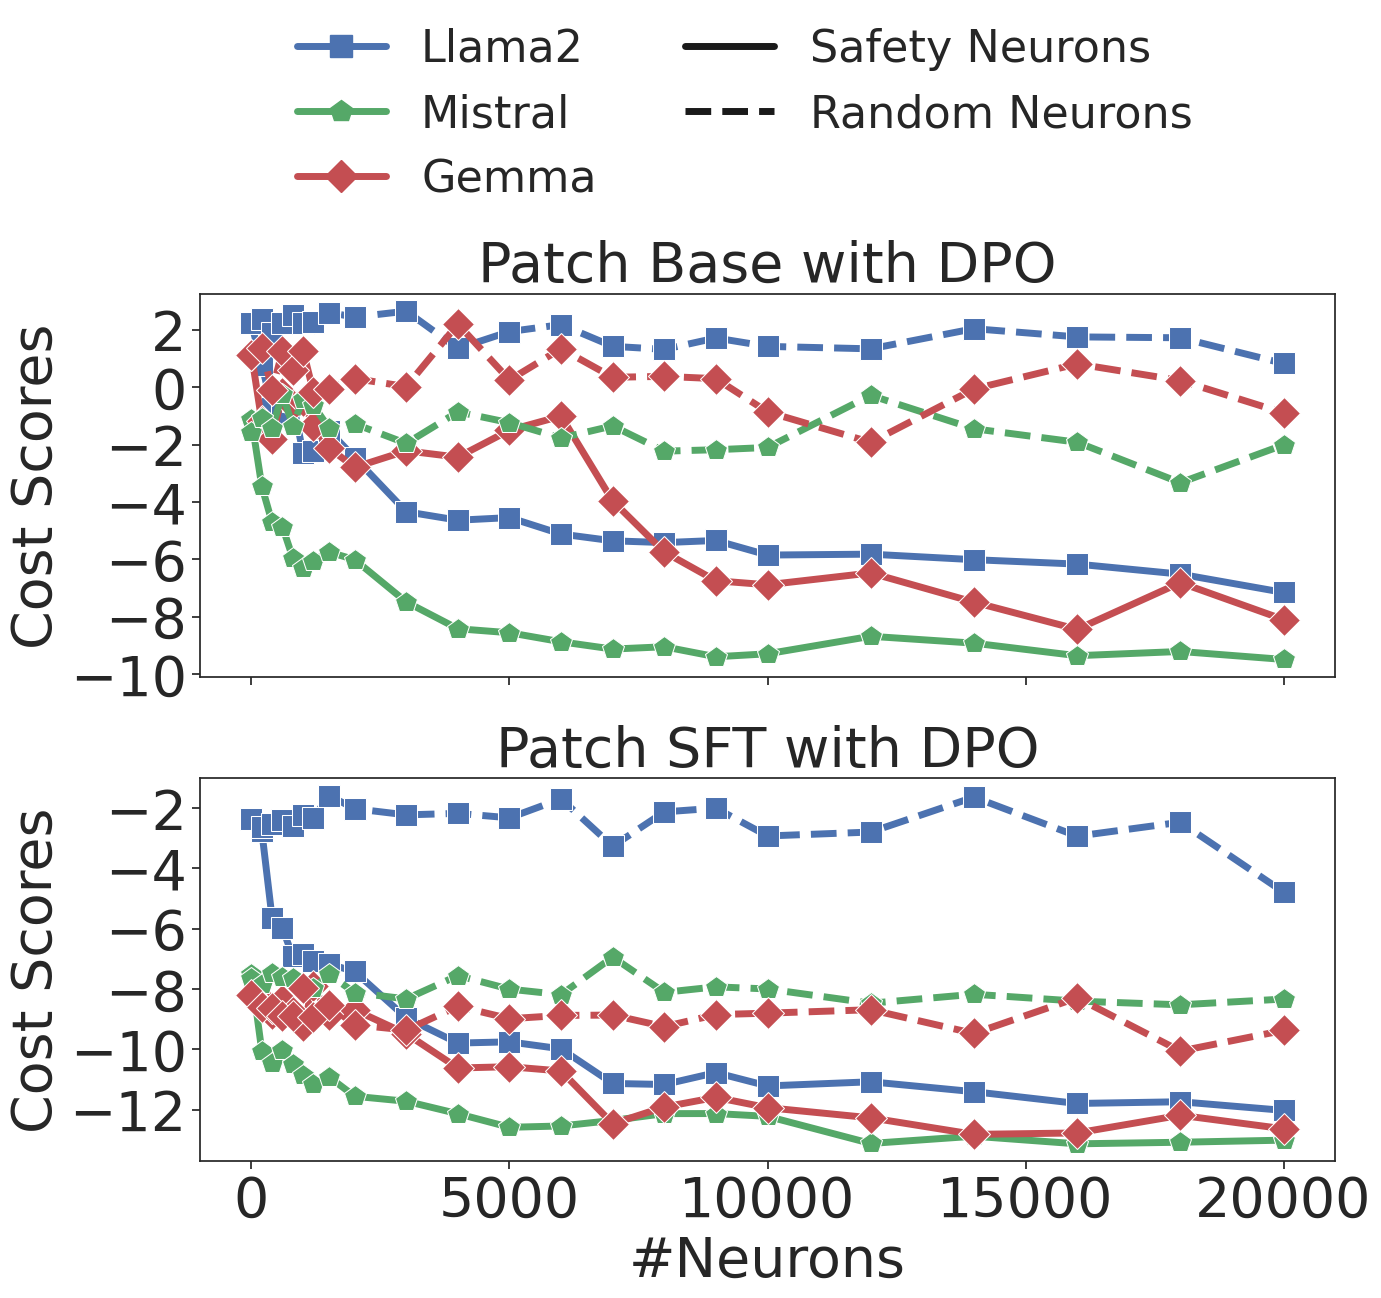

In [149]:
fontsize = 40
linewidth = 5
markersize = 16
sns.set_theme(style='ticks')
# Filter data for 'Base' and 'SFT'
df_base = df[df['peft'] == 'Base']
df_sft = df[df['peft'] == 'SFT']

# Initialize the plot
fig, axes = plt.subplots(2, 1, figsize=(14, 14), sharey=False, sharex=True)

# Define the colors and markers for each model
colors = {'Llama2': 'b', 'Mistral': 'g', 'Gemma': 'r'}
markers = {'Llama2': 's', 'Mistral': 'p', 'Gemma': 'D'}

# Plot for 'Base'
for neuron_type, linestyle in zip(['Safety Neurons', 'Random Neurons'], ['-', '--']):
    for model in df_base['Model'].unique():
        subset = df_base[(df_base['Model'] == model) & (df_base['Neuron Type'] == neuron_type)]
        if not subset.empty:
            sns.lineplot(
                data=subset,
                x='topk', y='cost', ax=axes[0],
                color=colors[model],
                marker=markers[model],
                linestyle=linestyle,
                linewidth=linewidth,
                markersize=markersize
            )

# Plot for 'SFT'
for neuron_type, linestyle in zip(['Safety Neurons', 'Random Neurons'], ['-', '--']):
    for model in df_sft['Model'].unique():
        subset = df_sft[(df_sft['Model'] == model) & (df_sft['Neuron Type'] == neuron_type)]
        if not subset.empty:
            sns.lineplot(
                data=subset,
                x='topk', y='cost', ax=axes[1],
                color=colors[model],
                marker=markers[model],
                linestyle=linestyle,
                linewidth=linewidth,
                markersize=markersize
            )

# Customize the plots
axes[0].set_title('Patch Base with DPO', fontsize=fontsize)
axes[0].set_xlabel('#Neurons', fontsize=fontsize)
axes[0].set_ylabel('Cost Scores', fontsize=fontsize)
axes[1].set_title('Patch SFT with DPO', fontsize=fontsize)
axes[1].set_xlabel('#Neurons', fontsize=fontsize)
axes[1].set_ylabel('Cost Scores', fontsize=fontsize)

for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='-', label='Safety Neurons'),
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='--', label='Random Neurons')
]

legend_elements = [Line2D([0], [0], color=colors[key], lw=linewidth, markersize=markersize, marker=markers[key], label=key) for key in colors.keys()] + legend_elements

# axes[0].legend(handles=legend_elements, title='Model and Neuron Type')
axes[0].legend(handles=legend_elements, title=None, ncol=2, fontsize=32, frameon=False, loc='upper left', bbox_to_anchor=(0.05, 1.8))

plt.tight_layout()
plt.savefig('./fig/patch_lineplot1.pdf', dpi=300, format='pdf', bbox_inches="tight")

### Sliding window

In [9]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
pefts = ['', '_sharegpt_ia3_ff_1']
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
data_sets = [
    # 'beavertails',
    'hh_harmless',
    # 'self_instruct',
    # 'hh_helpful'
]
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_hh_harmless_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
for model in models:
    for peft in pefts:
        for index in neuron_indexes:
            file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_{index}_window_20000.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Patched': 'w/'
            })
            dfs.append(new_df)
            new_df = pd.DataFrame({
                'topk': df.iloc[:, 1],
                'cost': df.iloc[:, 2],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Patched': 'w/o'
            })
            dfs.append(new_df)

df = pd.concat(dfs)

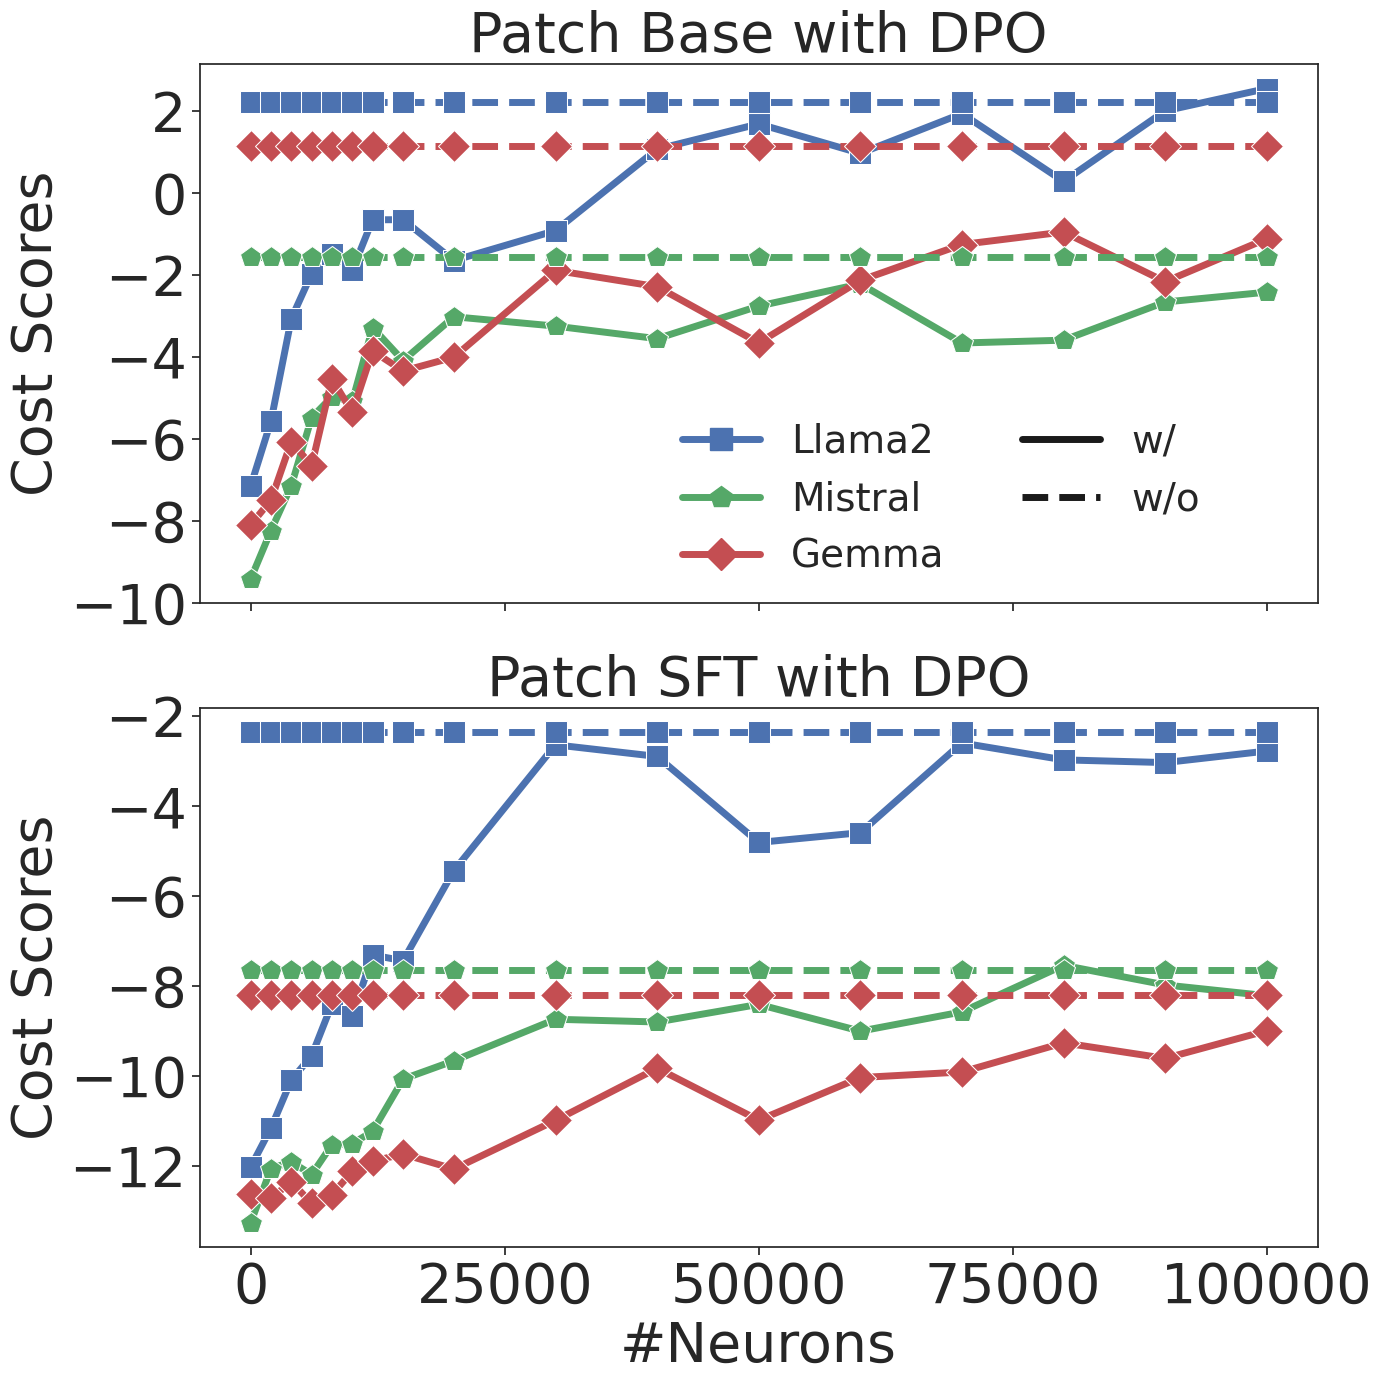

In [16]:
fontsize = 40
linewidth = 5
markersize = 16
sns.set_theme(style='ticks')
# Filter data for 'Base' and 'SFT'
df_base = df[df['peft'] == 'Base']
df_sft = df[df['peft'] == 'SFT']

# Initialize the plot
fig, axes = plt.subplots(2, 1, figsize=(14, 14), sharey=False, sharex=True)

# Define the colors and markers for each model
colors = {'Llama2': 'b', 'Mistral': 'g', 'Gemma': 'r'}
markers = {'Llama2': 's', 'Mistral': 'p', 'Gemma': 'D'}

# Plot for 'Base'
for neuron_type, linestyle in zip(['w/', 'w/o'], ['-', '--']):
    for model in df_base['Model'].unique():
        subset = df_base[(df_base['Model'] == model) & (df_base['Patched'] == neuron_type)]
        if not subset.empty:
            sns.lineplot(
                data=subset,
                x='topk', y='cost', ax=axes[0],
                color=colors[model],
                marker=markers[model],
                linestyle=linestyle,
                linewidth=linewidth,
                markersize=markersize
            )

# Plot for 'SFT'
for neuron_type, linestyle in zip(['w/', 'w/o'], ['-', '--']):
    for model in df_sft['Model'].unique():
        subset = df_sft[(df_sft['Model'] == model) & (df_sft['Patched'] == neuron_type)]
        if not subset.empty:
            sns.lineplot(
                data=subset,
                x='topk', y='cost', ax=axes[1],
                color=colors[model],
                marker=markers[model],
                linestyle=linestyle,
                linewidth=linewidth,
                markersize=markersize
            )

# Customize the plots
axes[0].set_title('Patch Base with DPO', fontsize=fontsize)
axes[0].set_xlabel('#Neurons', fontsize=fontsize)
axes[0].set_ylabel('Cost Scores', fontsize=fontsize)
axes[1].set_title('Patch SFT with DPO', fontsize=fontsize)
axes[1].set_xlabel('#Neurons', fontsize=fontsize)
axes[1].set_ylabel('Cost Scores', fontsize=fontsize)

for ax in axes:
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='-', label='w/'),
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='--', label='w/o')
]

legend_elements = [Line2D([0], [0], color=colors[key], lw=linewidth, markersize=markersize, marker=markers[key], label=key) for key in colors.keys()] + legend_elements

# axes[0].legend(handles=legend_elements, title='Model and Neuron Type')
axes[0].legend(handles=legend_elements, title=None, ncol=2, fontsize=28, frameon=False, loc='upper left', bbox_to_anchor=(0.4,0.4))

plt.tight_layout()
plt.savefig('./fig/sliding_window_patch_lineplot.pdf', dpi=300, format='pdf', bbox_inches="tight")

### 5 random seeds

In [55]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
seeds = [1, 42, 66, 88, 3407]
pefts = ['', '_sharegpt_ia3_ff_{}']
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
data_sets = [
    # 'beavertails',
    'hh_harmless',
    # 'self_instruct',
    # 'hh_helpful'
]
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_hh_harmless_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_{}_hh_harmless_dpo_ia3_ff'
for seed in seeds:
    for model in models:
        for peft in pefts:
            for index in neuron_indexes:
                file_path = folder_template.format(model, peft.format(seed), model, seed) + f'/guided_by_{model}_sharegpt_ia3_ff_{seed}_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_{seed}_hh_harmless_dpo_ia3_ff_{index}.csv'
                df = pd.read_csv(file_path)
                new_df = pd.DataFrame({
                    'topk': df.iloc[:,1],
                    'cost': df.iloc[:, 3],
                    'Model': model_name_map[model],
                    'Patched': 'SFT' if peft else 'Base',
                    'seed': seed
                })
                dfs.append(new_df)

df = pd.concat(dfs)

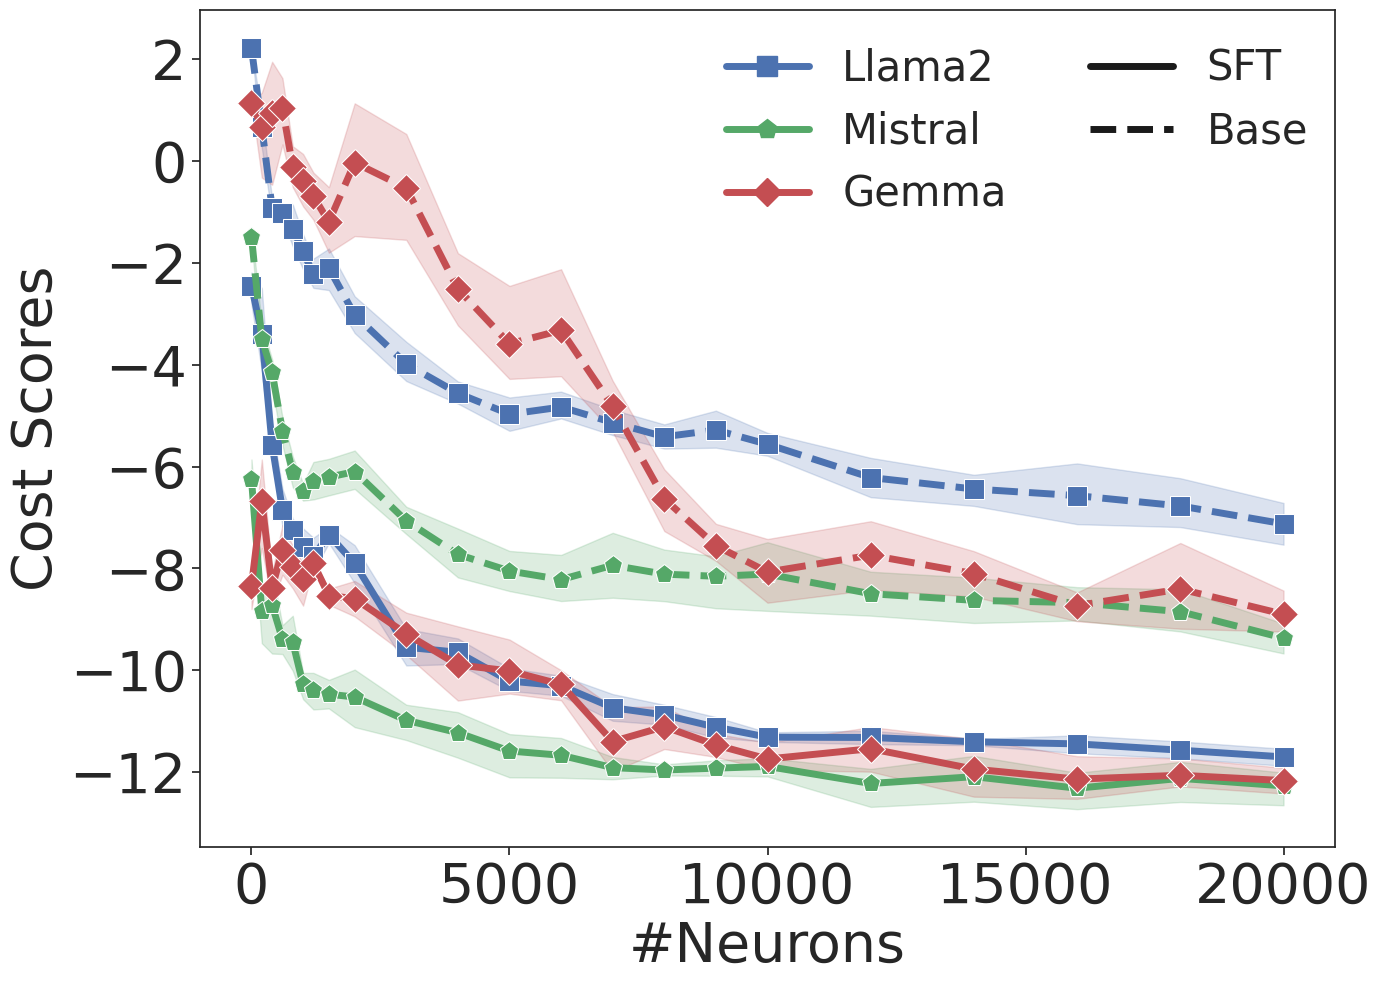

In [70]:
fontsize = 40
linewidth = 5
markersize = 14
sns.set_theme(style='ticks')

# Initialize the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define the colors and markers for each model
colors = {'Llama2': 'b', 'Mistral': 'g', 'Gemma': 'r'}
markers = {'Llama2': 's', 'Mistral': 'p', 'Gemma': 'D'}

# Plot for 'Base'
for patch_type, linestyle in zip(['SFT', 'Base'], ['-', '--']):
    for model in df['Model'].unique():
        subset = df[(df['Model'] == model) & (df['Patched'] == patch_type)]
        if not subset.empty:
            sns.lineplot(
                data=subset,
                x='topk', y='cost', ax=ax,
                color=colors[model],
                marker=markers[model],
                linestyle=linestyle,
                linewidth=linewidth,
                markersize=markersize,
                errorbar=('ci', 95)
            )



# Customize the plots
ax.set_xlabel('#Neurons', fontsize=fontsize)
ax.set_ylabel('Cost Scores', fontsize=fontsize)

ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.setp(ax.get_xticklabels(), fontsize=fontsize)
plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    
# Create custom legend
legend_elements = [
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='-', label='SFT'),
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='--', label='Base')
]

legend_elements = [Line2D([0], [0], color=colors[key], lw=linewidth, markersize=markersize, marker=markers[key], label=key) for key in colors.keys()] + legend_elements

# axes[0].legend(handles=legend_elements, title='Model and Neuron Type')
ax.legend(handles=legend_elements, title=None, ncol=2, fontsize=30, frameon=False, loc='upper left', bbox_to_anchor=(0.43,1.0))

plt.tight_layout()
plt.savefig('./fig/5_random_seeds.pdf', dpi=300, format='pdf', bbox_inches="tight")

### Different datasets

In [62]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
pefts = ['', '_sharegpt_ia3_ff_1']
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
data_sets = [
    'beavertails',
    'hh_harmless',
    'jailbreak_llms',
    'hh_helpful',
    'lima',
    'rewardbench_reasoning',
]
labels = ['Beavertails', 'HH-Harmless', 'JailBreakLLMs', 'HH-Helpful', 'LIMA', 'Reasoning']
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_{}_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
for dataset, label in zip(data_sets, labels):
    for model in models:
        for peft in pefts:
            for index in neuron_indexes:
                file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_{index.format(dataset)}.csv'
                df = pd.read_csv(file_path)
                new_df = pd.DataFrame({
                    'topk': df.iloc[:,1],
                    'cost': df.iloc[:, 3],
                    'peft': 'SFT' if peft else 'Base',
                    'Prompt Dataset': label,
                    'model': model
                })
                dfs.append(new_df)
df = pd.concat(dfs)

#### Multiple Models

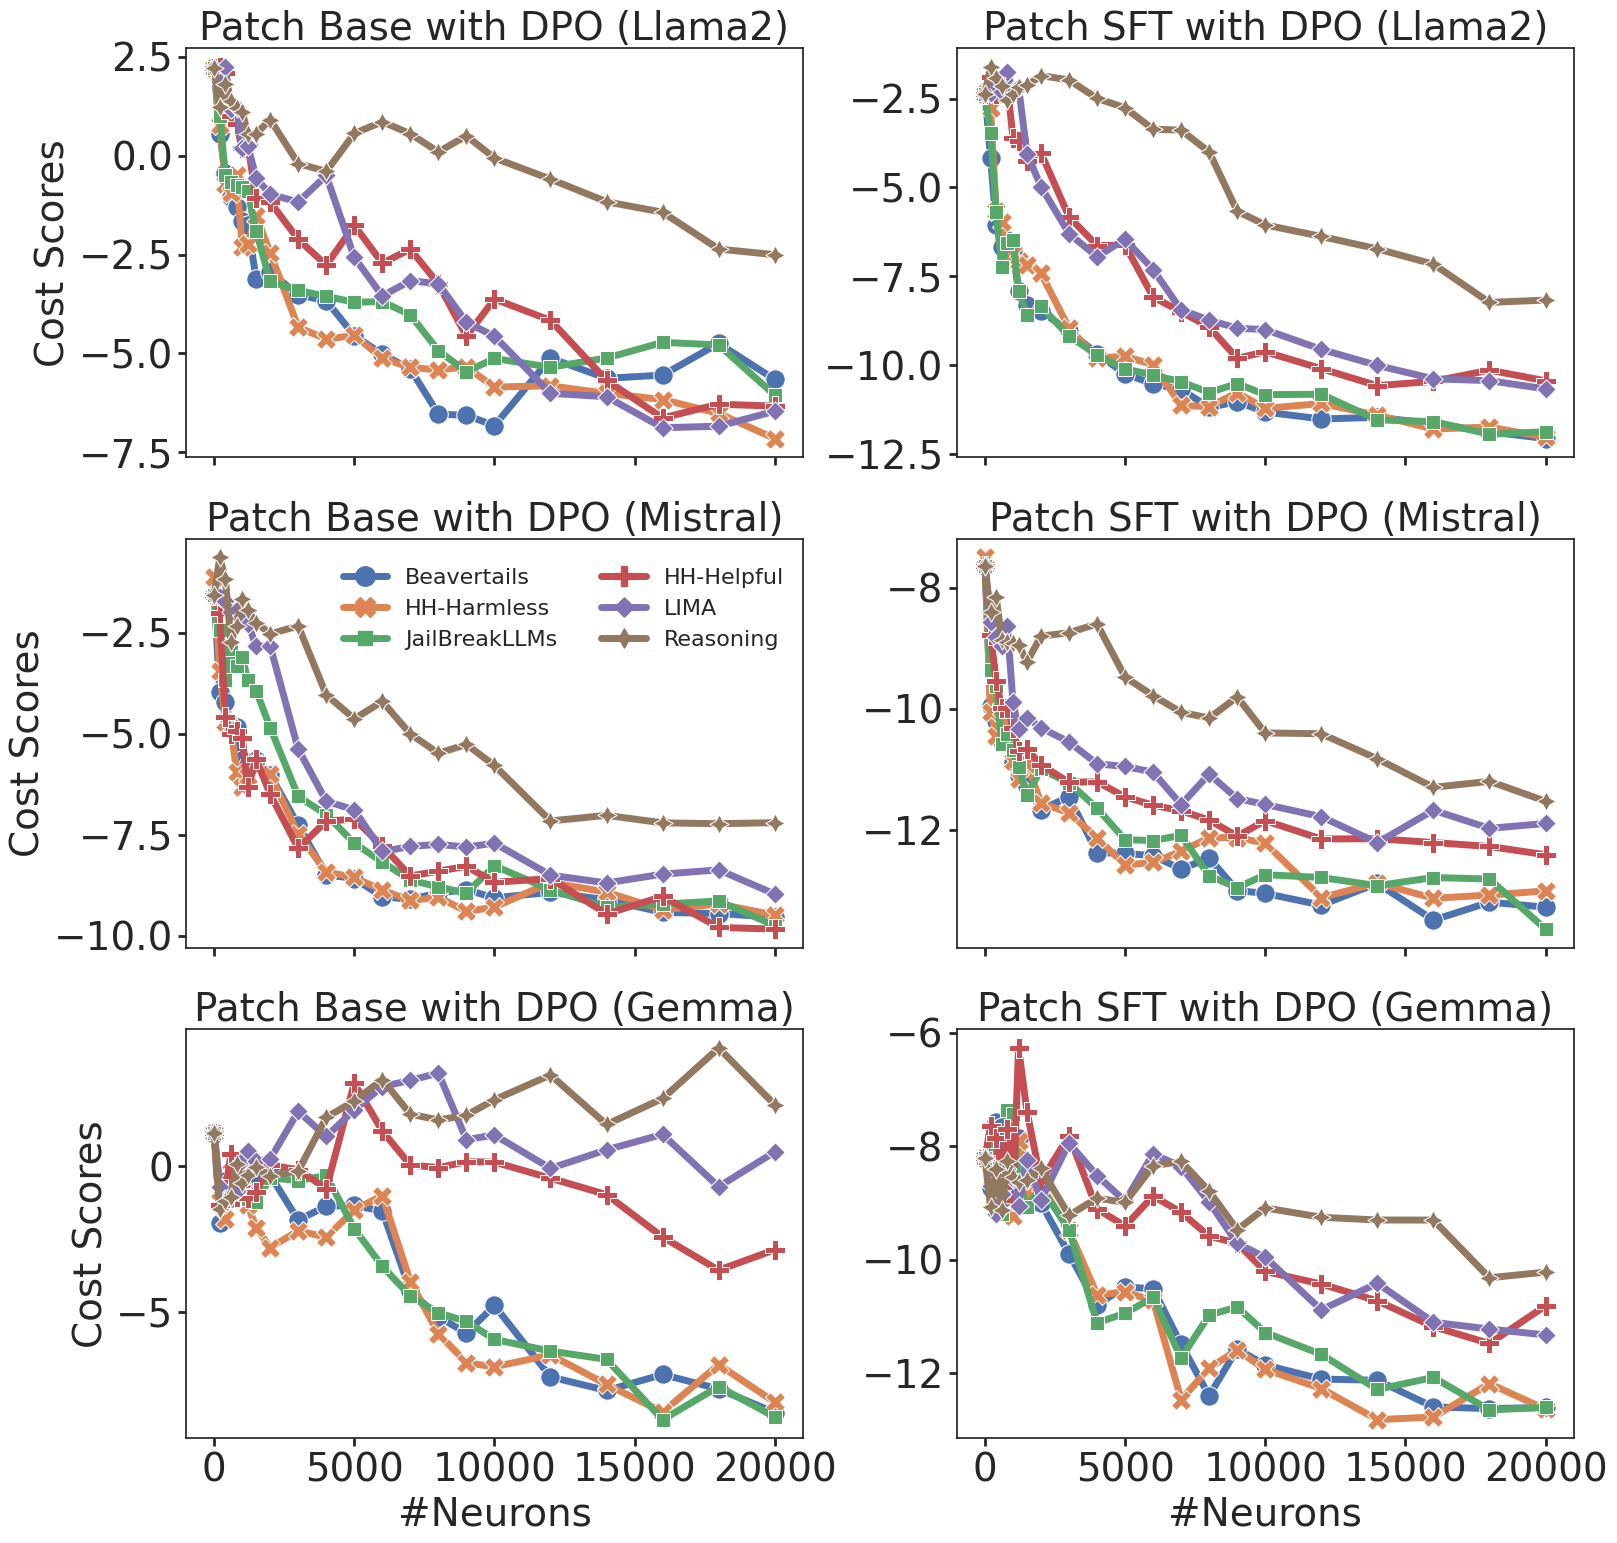

In [78]:
fontsize = 28
sns.set_theme(style='ticks')
model_names = ['Llama2', 'Mistral', 'Gemma']
patch_names = ['Patch Base with DPO', 'Patch SFT with DPO']
g = sns.relplot(x='topk', y='cost', data=df, hue='Prompt Dataset', col='peft', row='model', kind='line', style='Prompt Dataset', aspect=1.5, facet_kws=dict(sharey=False), linewidth=5, dashes=False, markers=True, markersize=14)
g.set_axis_labels(x_var='#Neurons', y_var='Cost Scores', fontsize=fontsize, fontweight=500)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
# g.axes[0, 0].set_ylim(-8, 4)
# g.axes[0, 0].set_title('Patch Base with DPO', fontsize=fontsize)
# g.axes[1, 0].set_ylim(-14, 0)
# g.axes[1, 0].set_title('Patch SFT with DPO', fontsize=fontsize)
for i in range(len(model_names)):
    for j in range(len(patch_names)):
        g.axes[i, j].set_title(f'{patch_names[j]} ({model_names[i]})', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2, wspace=0.25)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.14,0.64), fontsize=16, frameon=False, ncol=2)
# Access the legend object and modify font properties
legend = g._legend
legend.set_title(None)
# Define a custom font
# custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)
# legend.get_title().set_fontproperties(custom_font)
for ax in g.axes.flat:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
plt.savefig('./fig/different_datasets.pdf', dpi=300, format='pdf', bbox_inches="tight")

### Different models

In [22]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
dpos = [
    'hh_harmless', 
    'rewardbench_safety',
    'hh_helpful',
    'shp',
    'H4_stack_exchange',
    'rewardbench_reasoning',
    'IEFeedback'
]
labels = ['Harmless', 'Safety', 'Helpful', 'SHP', 'HSE', 'Reasoning', 'IEFeedback']
neuron_indexes = [
    # 'base_vs_dpo_on_{}_base_completion',
    # 'base_vs_dpo_on_{}_dpo_completion',
    'sft_vs_dpo_on_hh_harmless_sft_completion',
    # 'sft_vs_dpo_on_{}_dpo_completion'
]
dfs = []
folder_template = '../results/arena/{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_vs_{}_sharegpt_ia3_ff_1_hh_helpful_dpo_ia3_ff'
for dpo, label in zip(dpos, labels):
    for model in models[:1]:
        for index in neuron_indexes:
            file_path = folder_template.format(model, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_helpful_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_{dpo}_dpo_ia3_ff_{index}.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Alignment Dataset': label,
                'model': model
            })
            dfs.append(new_df)
df = pd.concat(dfs)

#### Single Model

/tmp/ipykernel_4094644/135237738.py:6: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  g = sns.relplot(x='topk', y='cost', data=df, style='Alignment Dataset', hue='Alignment Dataset', dashes=False, kind='line', aspect=1.4, facet_kws=dict(sharey=False), linewidth=linewidth, height=8, palette=palette, markers=True, markersize=markersize)


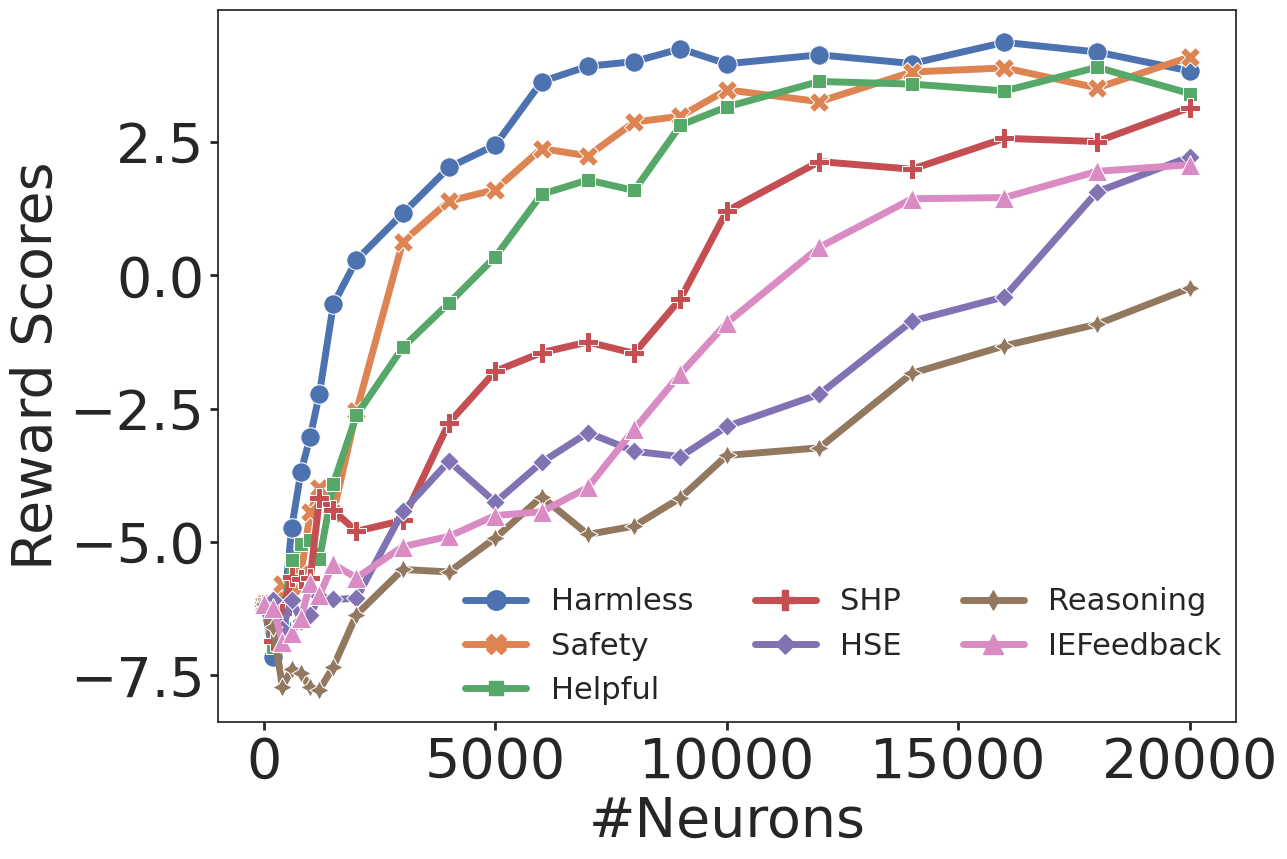

In [23]:
fontsize = 40
linewidth = 5
markersize = 14
sns.set_theme(style='ticks')
palette = sns.color_palette()
g = sns.relplot(x='topk', y='cost', data=df, style='Alignment Dataset', hue='Alignment Dataset', dashes=False, kind='line', aspect=1.4, facet_kws=dict(sharey=False), linewidth=linewidth, height=8, palette=palette, markers=True, markersize=markersize)
g.set_axis_labels(x_var='#Neurons', y_var='Reward Scores', fontsize=fontsize, fontweight=500)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.24,0.29), fontsize=22, frameon=False, ncol=3)
# Access the legend object and modify font properties
legend = g._legend
legend.set_title(None)
# Define a custom font
# custom_font = font_manager.FontProperties(style='normal', weight=700, size=15)
# legend.get_title().set_fontproperties(custom_font)
for ax in g.axes.flat:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)

plt.savefig('./fig/different_models_grid.pdf', dpi=300, format='pdf', bbox_inches="tight")

#### Mutiple Models

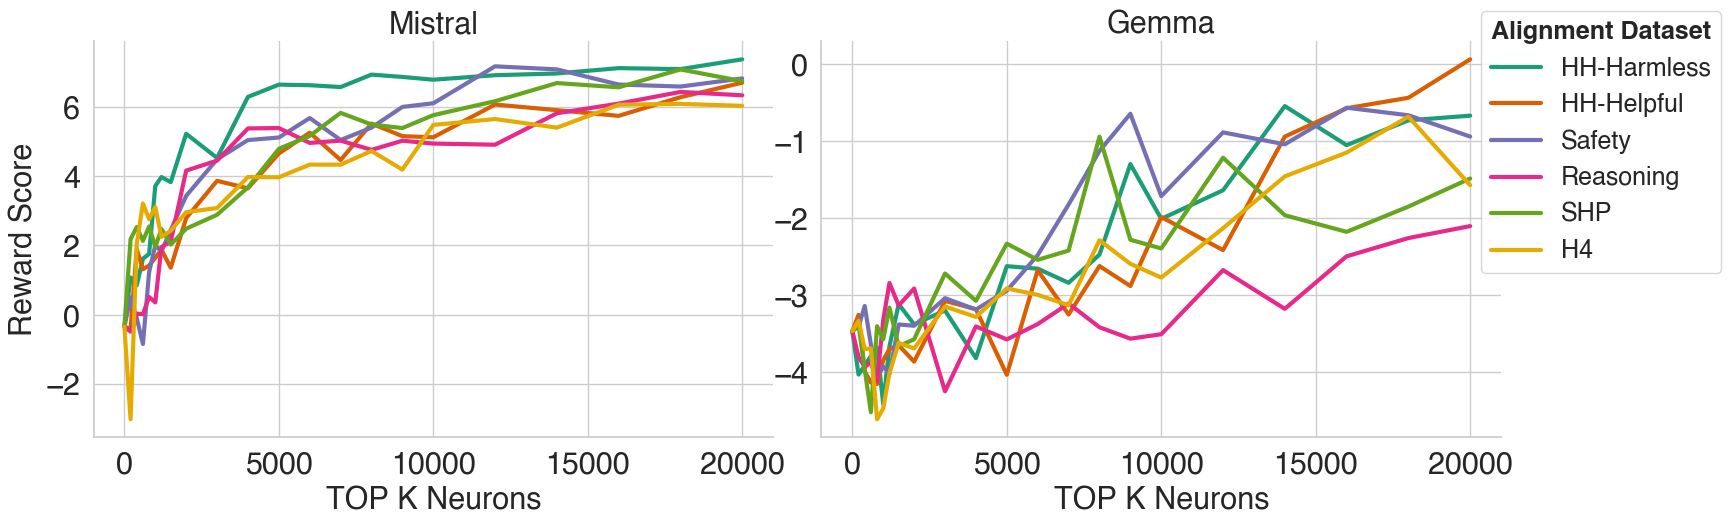

In [28]:
fontsize = 22
g = sns.relplot(x='topk', y='cost', data=df, col='model', hue='Alignment Dataset', kind='line', aspect=1.5, facet_kws=dict(sharey=False), linewidth=3)
g.set_axis_labels(x_var='TOP K Neurons', y_var='Reward Score', fontsize=fontsize, fontweight=500)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
g.axes[0, 0].set_title('Mistral', fontsize=fontsize)
g.axes[0, 1].set_title('Gemma', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.88,1.01), fontsize=18, frameon=True)
# Access the legend object and modify font properties
legend = g._legend
# Define a custom font
custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)
legend.get_title().set_fontproperties(custom_font)
plt.savefig('./fig/different_models_mistral_gemma.pdf', dpi=600, format='pdf', bbox_inches="tight")

### Ablation study

In [31]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
pefts = ['', '_sharegpt_ia3_ff_1']
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
data_sets = [
    # 'beavertails',
    'hh_harmless',
    # 'self_instruct',
    # 'hh_helpful'
]
neuron_indexes = [
    'base_vs_dpo_on_hh_harmless_base_completion',
    'base_vs_dpo_on_hh_harmless_dpo_completion',
    'sft_vs_dpo_on_hh_harmless_sft_completion',
    'sft_vs_dpo_on_hh_harmless_dpo_completion'
]
legends = [
    ['Base and DPO', 'First Model'],
    ['Base and DPO', 'Second Model'],
    ['SFT and DPO', 'First Model'],
    ['SFT and DPO', 'Second Model']
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
for model in models:
    for peft in pefts:
        for index, legend in zip(neuron_indexes, legends):
            file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_{index}.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Compared Models': legend[0],
                'Generation': legend[1]
            })
            dfs.append(new_df)

df = pd.concat(dfs)

#### Multiple Models

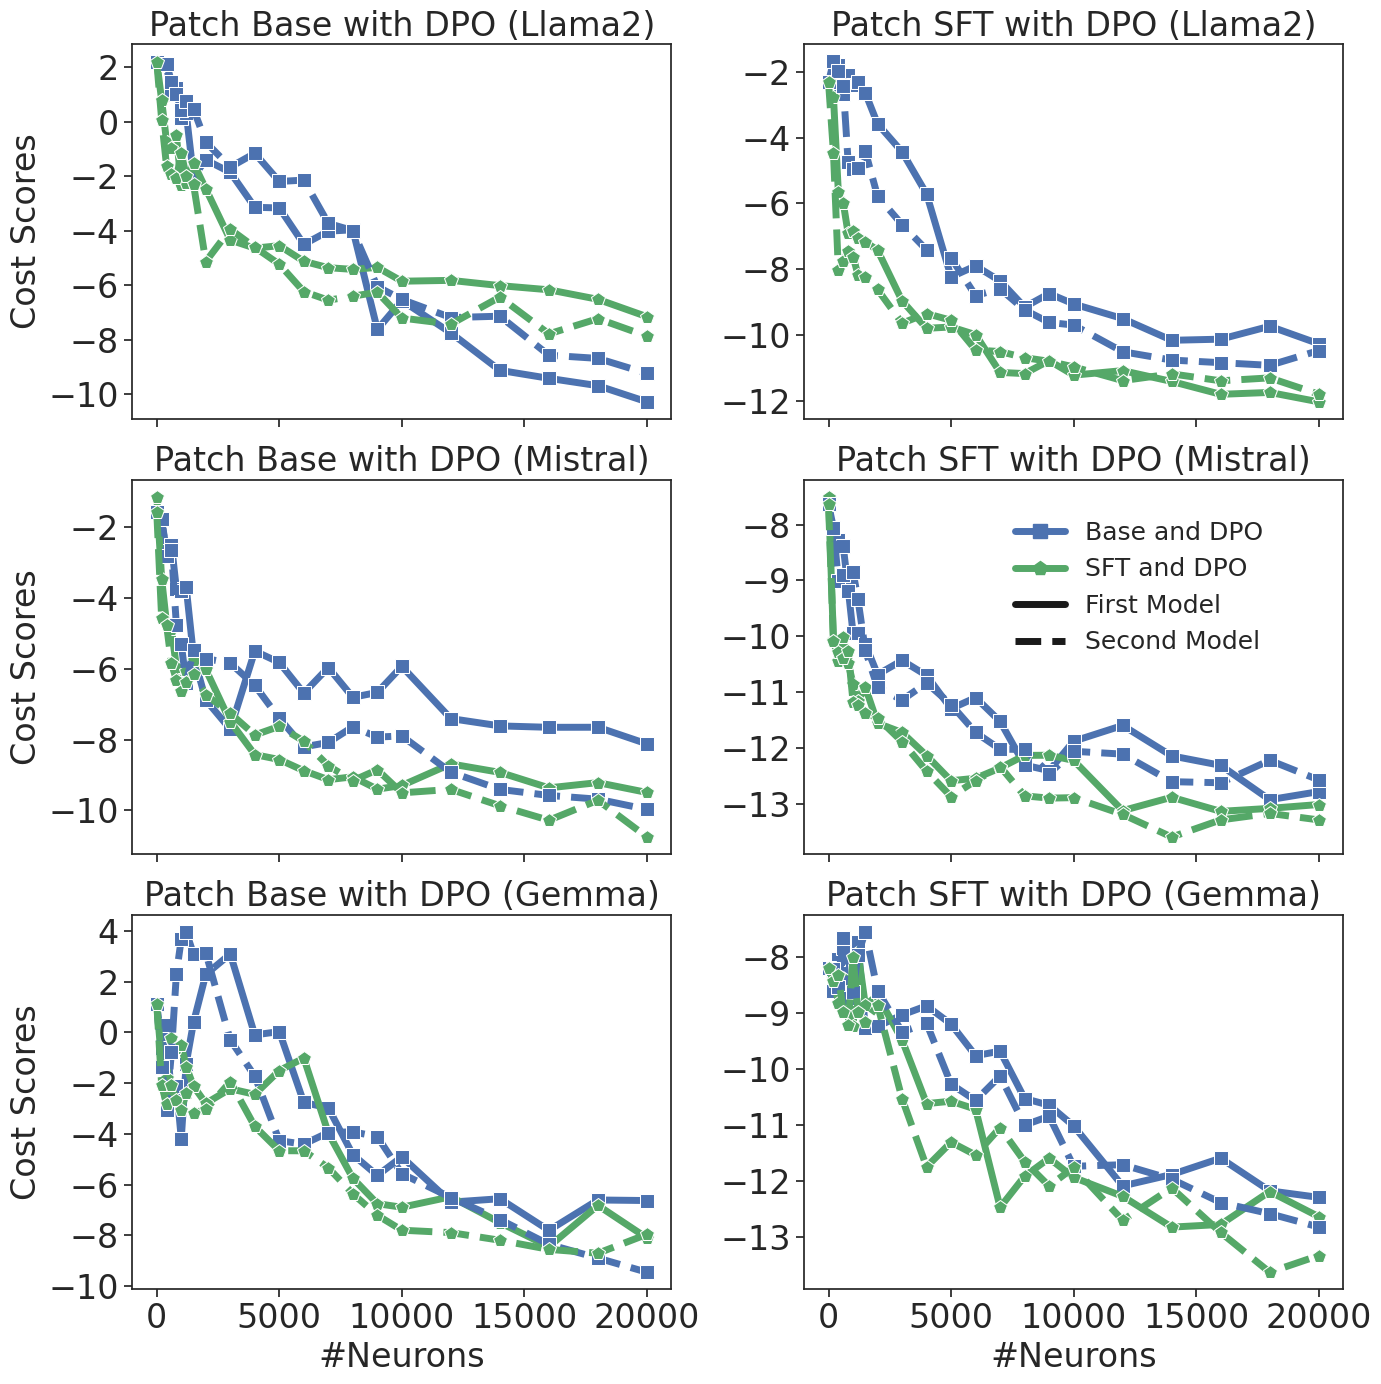

In [60]:
fontsize = 24
linewidth = 5
markersize = 10
sns.set_theme(style='ticks')
# Initialize the plot

fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharey=False, sharex=True)

# Define the colors and markers for each model
colors = {'Base and DPO': 'b', 'SFT and DPO': 'g'}
markers = {'Base and DPO': 's', 'SFT and DPO': 'p'}

for i, model in enumerate(models):
    for j, peft in enumerate(['Base', 'SFT']):
        df_temp = df[(df['Model'] == model_name_map[model]) & (df['peft'] == peft)]
        for gmodel, linestyle in zip(['First Model', 'Second Model'], ['-', '--']):
            for cmodel in df_temp['Compared Models'].unique():
                subset = df_temp[(df_temp['Compared Models'] == cmodel) & (df_temp['Generation'] == gmodel)]
                if not subset.empty:
                    sns.lineplot(
                        data=subset,
                        x='topk', y='cost', ax=axes[i][j],
                        color=colors[cmodel],
                        marker=markers[cmodel],
                        linestyle=linestyle,
                        linewidth=linewidth,
                        markersize=markersize
                    )

# Customize the plots
for i, patch_type in enumerate(['Patch Base with DPO', 'Patch SFT with DPO']):
    for j, model_name in enumerate(models):
        axes[j][i].set_title(f'{patch_type} ({model_name_map[model_name]})', fontsize=fontsize)
        if i == 0:
            axes[j][i].set_ylabel('Cost Scores', fontsize=fontsize)
        else:
            axes[j][i].set_ylabel(None, fontsize=fontsize)
        if j == 2:
            axes[j][i].set_xlabel('#Neurons', fontsize=fontsize)
        axes[j][i].xaxis.set_major_locator(MaxNLocator(nbins=5))
        plt.setp(axes[j][i].get_xticklabels(), fontsize=fontsize)
        plt.setp(axes[j][i].get_yticklabels(), fontsize=fontsize)
            


    
# # Create custom legend
legend_elements = [
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='-', label='First Model'),
    Line2D([0], [0], color='k', lw=linewidth, markersize=markersize, linestyle='--', label='Second Model')
]

legend_elements = [Line2D([0], [0], color=colors[key], lw=linewidth, markersize=markersize, marker=markers[key], label=key) for key in colors.keys()] + legend_elements


axes[1][1].legend(handles=legend_elements, title=None, ncol=1, fontsize=18, frameon=False, loc='upper left', bbox_to_anchor=(0.35,0.95))

plt.tight_layout()
plt.savefig('./fig/which_model.pdf', dpi=300, format='pdf', bbox_inches="tight")

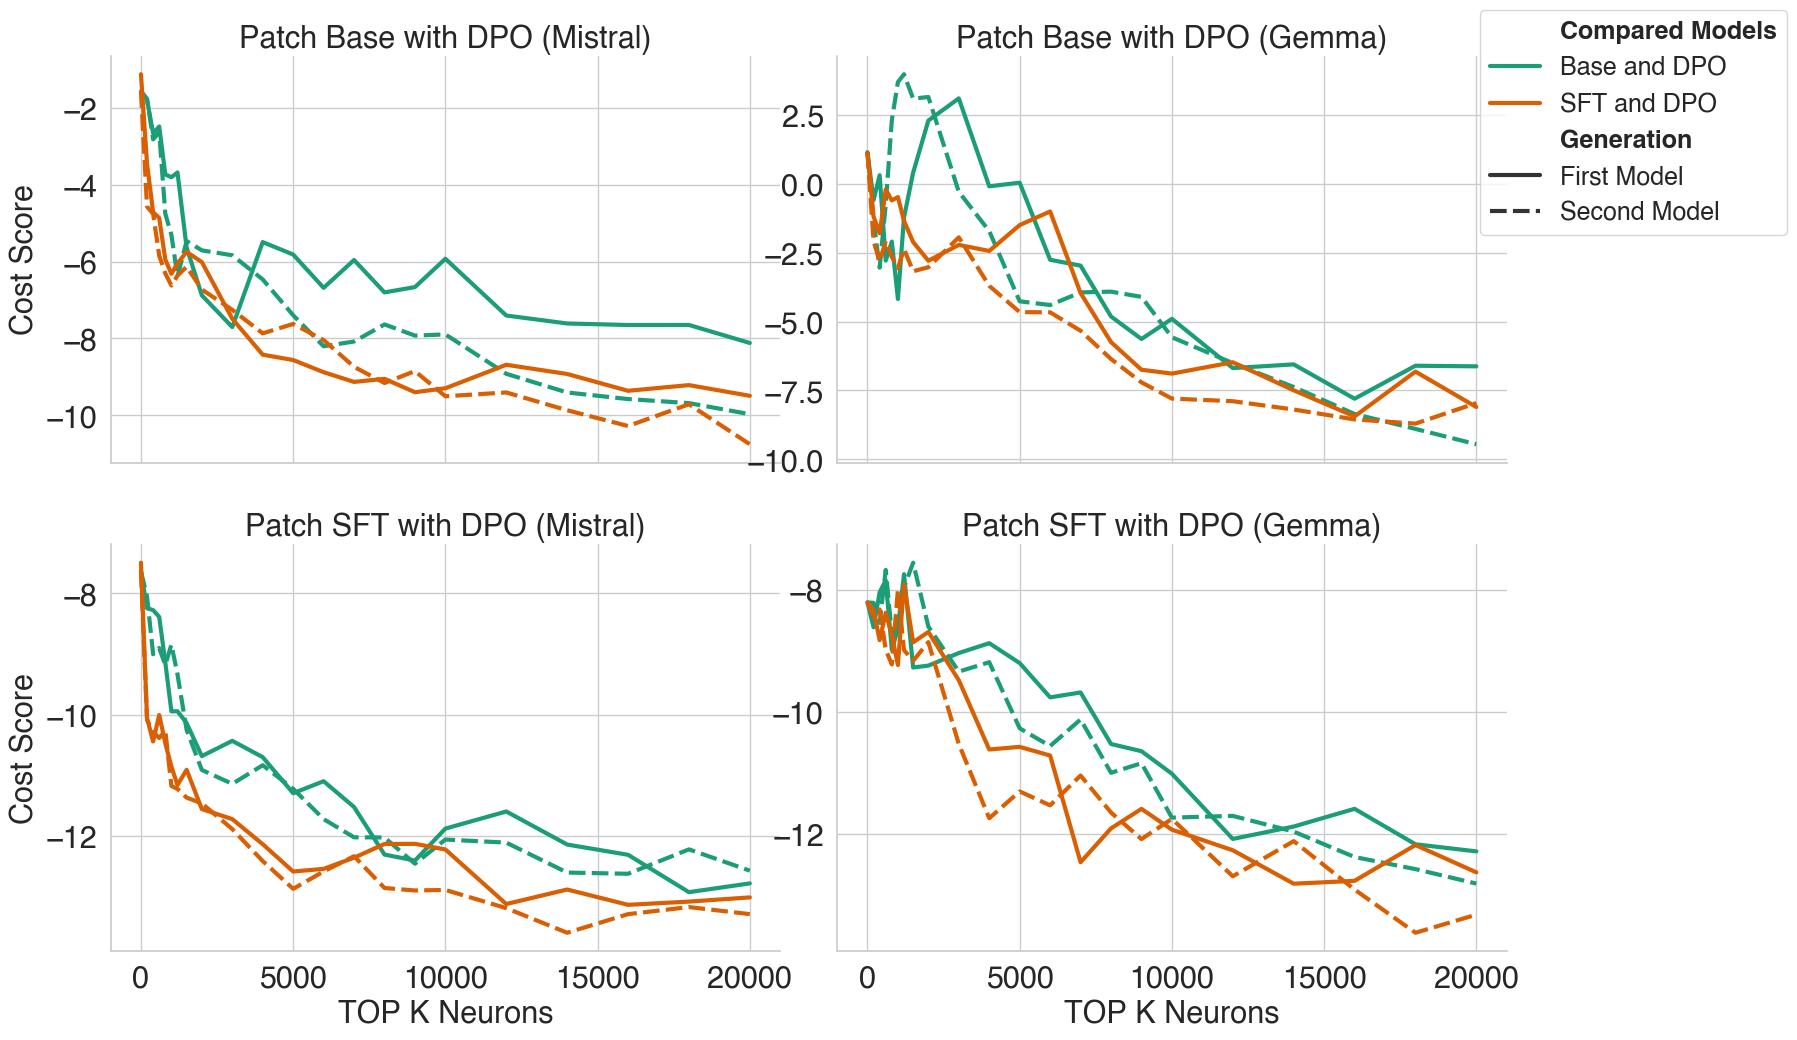

In [59]:
fontsize = 28
g = sns.relplot(x='topk', y='cost', data=df, hue='Compared Models', style='Generation', row='Model', col='peft', kind='line', aspect=1.5, facet_kws=dict(sharey=False), linewidth=3)
g.set_axis_labels(x_var='TOP K Neurons', y_var='Cost Score', fontsize=fontsize, fontweight=500)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
for i in range(2):
    for j in range(2):
        g.axes[i, j].set_title(f'{patch_names[i]} ({model_names[j]})', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.86,1.02), fontsize=18, frameon=True)
# Access the legend object and modify font properties
legend = g._legend
# Define a custom font
custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)

# Loop through the legend texts and apply font changes based on the label
for text in legend.texts:
    if text.get_text() == 'Compared Models' or text.get_text() == 'Generation':
        text.set_fontproperties(custom_font)

# plt.savefig('./fig/which_model_mistral_gemma.pdf', dpi=600, format='pdf', bbox_inches="tight")

In [60]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
pefts = ['', '_sharegpt_ia3_ff_1']
# titiles = ['Patch Base with DPO', 'Patch SFT with DPO']
data_sets = [
    # 'beavertails',
    'hh_harmless',
    # 'self_instruct',
    # 'hh_helpful'
]
neuron_indexes = [
    'difference_on_hh_prompt_last_token',
    'std_on_hh_prompt_last_token',
    'sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_sft_vs_dpo_on_hh_harmless_sft_completion',
]
labels = [
    'Prompt Difference',
    'Activation Variance',
    'Safety Neurons'
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
for model in models[1:]:
    for peft in pefts:
        for index, label in zip(neuron_indexes, labels):
            file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_{index}.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Method': label
            })
            dfs.append(new_df)

df = pd.concat(dfs)

#### Single Model

In [ ]:
fontsize = 22
g = sns.relplot(x='topk', y='cost', data=df, hue='Method', row='peft', kind='line', aspect=2, facet_kws=dict(sharey=False), linewidth=3)
g.set_axis_labels(x_var='TOP K Neurons', y_var='Cost Score', fontsize=fontsize)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
g.axes[0, 0].set_ylim(-10, 10)
g.axes[0, 0].set_title('Patch Base with DPO', fontsize=fontsize)
g.axes[1, 0].set_ylim(-14, 0)
g.axes[1, 0].set_title('Patch SFT with DPO', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2)
# Define a custom font
custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)
g._legend.get_title().set_fontproperties(custom_font)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.58,1.02), fontsize=18, frameon=True)
plt.savefig('./fig/different_methods.pdf', dpi=600, format='pdf', bbox_inches="tight")

#### Multiple Models

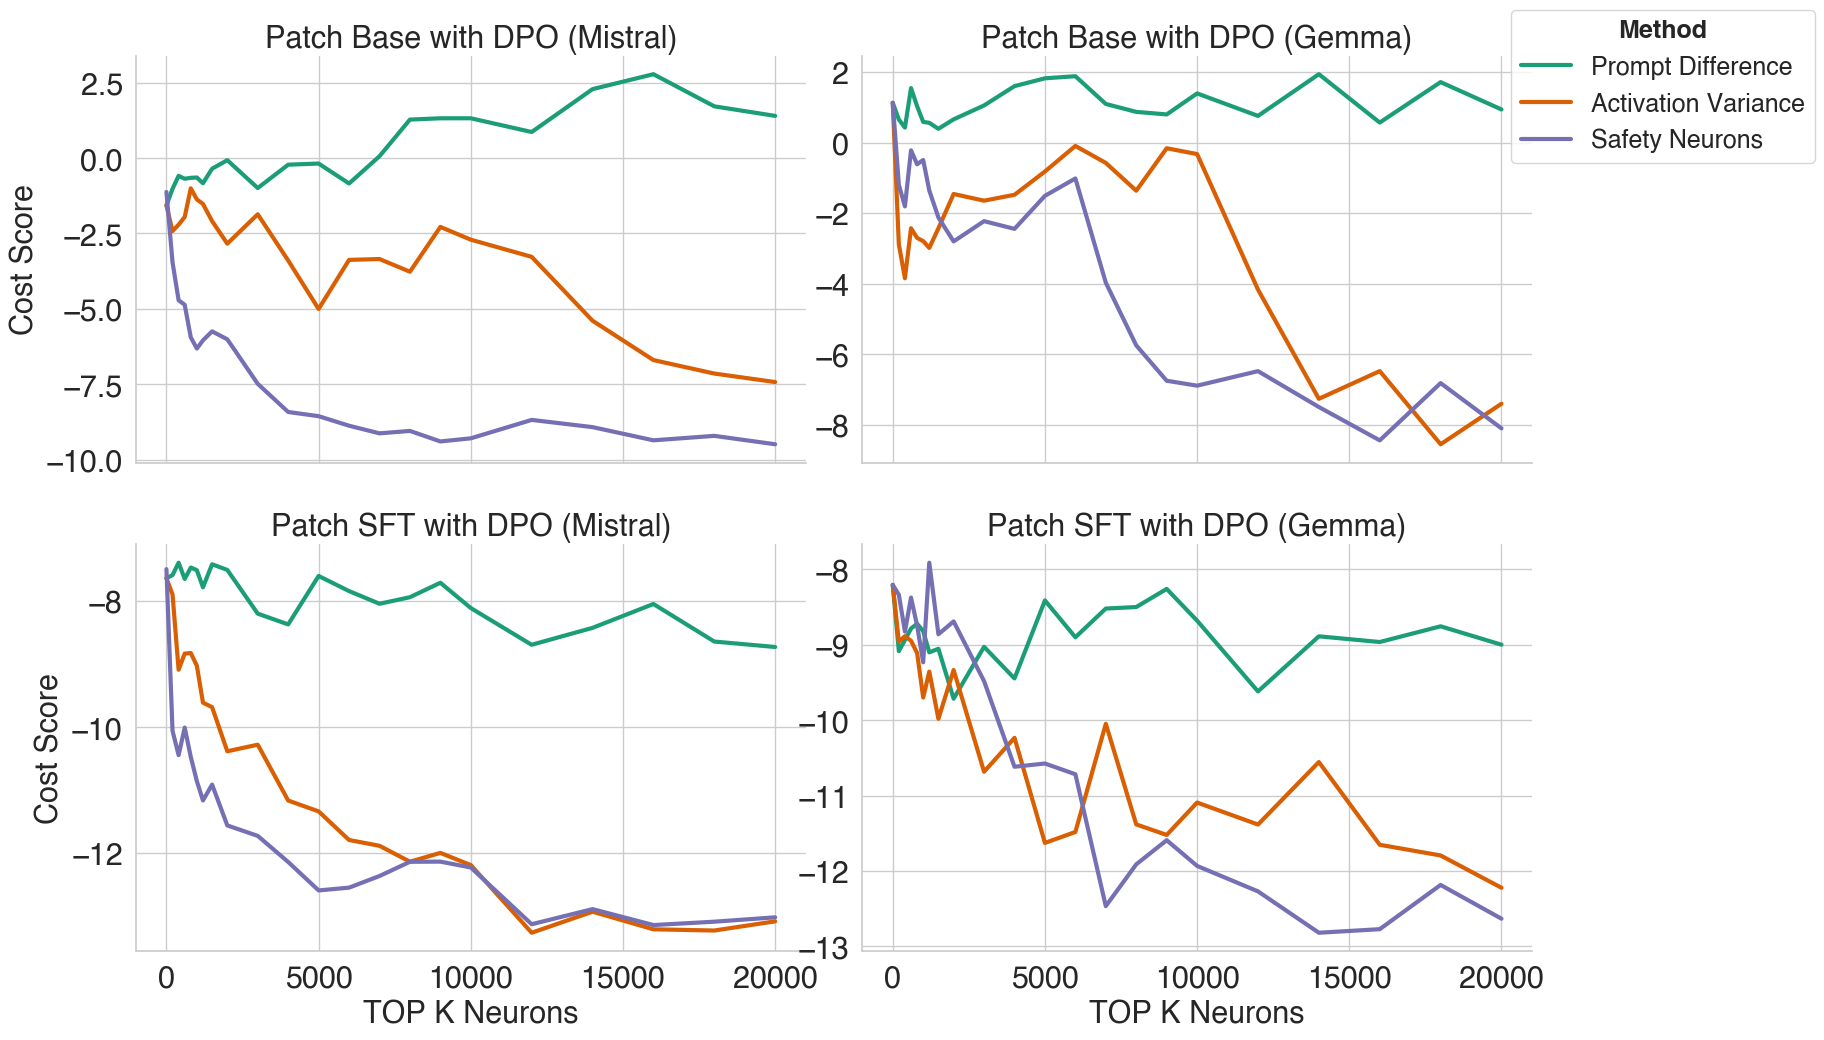

In [64]:
fontsize = 22
g = sns.relplot(x='topk', y='cost', data=df, hue='Method', row='peft', col='Model', kind='line', aspect=1.5, facet_kws=dict(sharey=False), linewidth=3)
g.set_axis_labels(x_var='TOP K Neurons', y_var='Cost Score', fontsize=fontsize)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
for i in range(2):
    for j in range(2):
        g.axes[i, j].set_title(f'{patch_names[i]} ({model_names[j]})', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2)
# Define a custom font
custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)
g._legend.get_title().set_fontproperties(custom_font)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.86,1.02), fontsize=18, frameon=True)
plt.savefig('./fig/different_methods_mistral_gemma.pdf', dpi=600, format='pdf', bbox_inches="tight")

In [80]:
models = ['Llama-2-7b-hf', 'Mistral-7B-v0.1', 'gemma-7b']
model_name_map = {'Llama-2-7b-hf': 'Llama2', 'Mistral-7B-v0.1': 'Mistral', 'gemma-7b': 'Gemma'}
pefts = ['', '_sharegpt_ia3_ff_1']

neuron_indexes = [
    'sft_vs_dpo_on_hh_harmless_prompt',
    'sft_vs_dpo_on_hh_harmless_prompt_last',
    'sft_vs_dpo_on_hh_harmless_sft_completion'
]
labels = [
    'Prompt (all tokens)',
    'Prompt (last token)',
    'Safety Neurons'
]
dfs = []
folder_template = '../results/arena/{}{}_vs_{}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
for model in models:
    for peft in pefts:
        for index, label in zip(neuron_indexes, labels):
            file_path = folder_template.format(model, peft, model) + f'/guided_by_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_idx_{model}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_{index}.csv'
            df = pd.read_csv(file_path)
            new_df = pd.DataFrame({
                'topk': df.iloc[:,1],
                'cost': df.iloc[:, 3],
                'Model': model_name_map[model],
                'peft': 'SFT' if peft else 'Base',
                'Token Position': label
            })
            dfs.append(new_df)

df = pd.concat(dfs)

#### Single Model

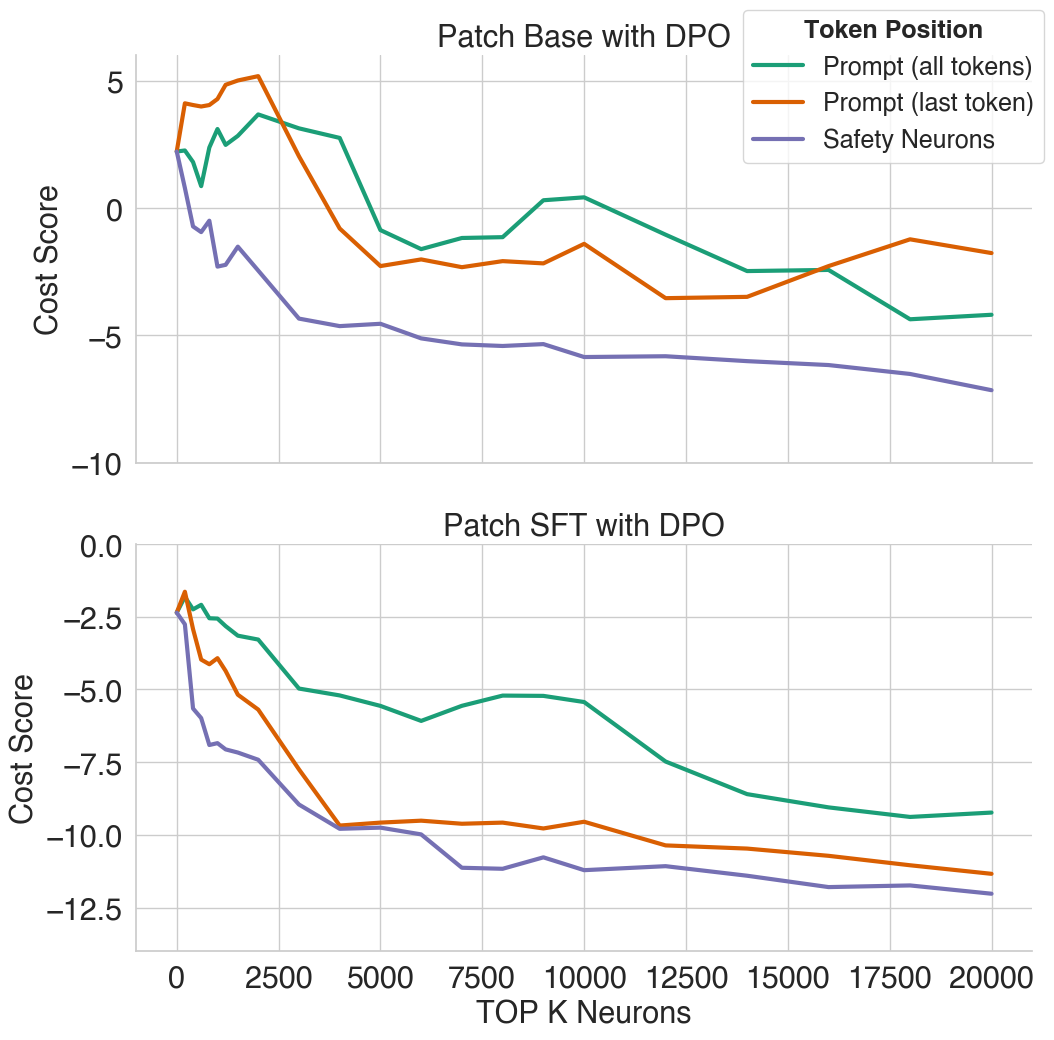

In [8]:
fontsize = 22
g = sns.relplot(x='topk', y='cost', data=df, hue='Token Position', row='peft', kind='line', aspect=2, facet_kws=dict(sharey=False), linewidth=3)
g.set_axis_labels(x_var='TOP K Neurons', y_var='Cost Score', fontsize=fontsize)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
g.axes[0, 0].set_ylim(-10, 6)
g.axes[0, 0].set_title('Patch Base with DPO', fontsize=fontsize)
g.axes[1, 0].set_ylim(-14, 0)
g.axes[1, 0].set_title('Patch SFT with DPO', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2)
# Define a custom font
custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)
g._legend.get_title().set_fontproperties(custom_font)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.58,1.02), fontsize=18, frameon=True)
plt.savefig('./fig/different_positions.pdf', dpi=600, format='pdf', bbox_inches="tight")

#### Multiple Models

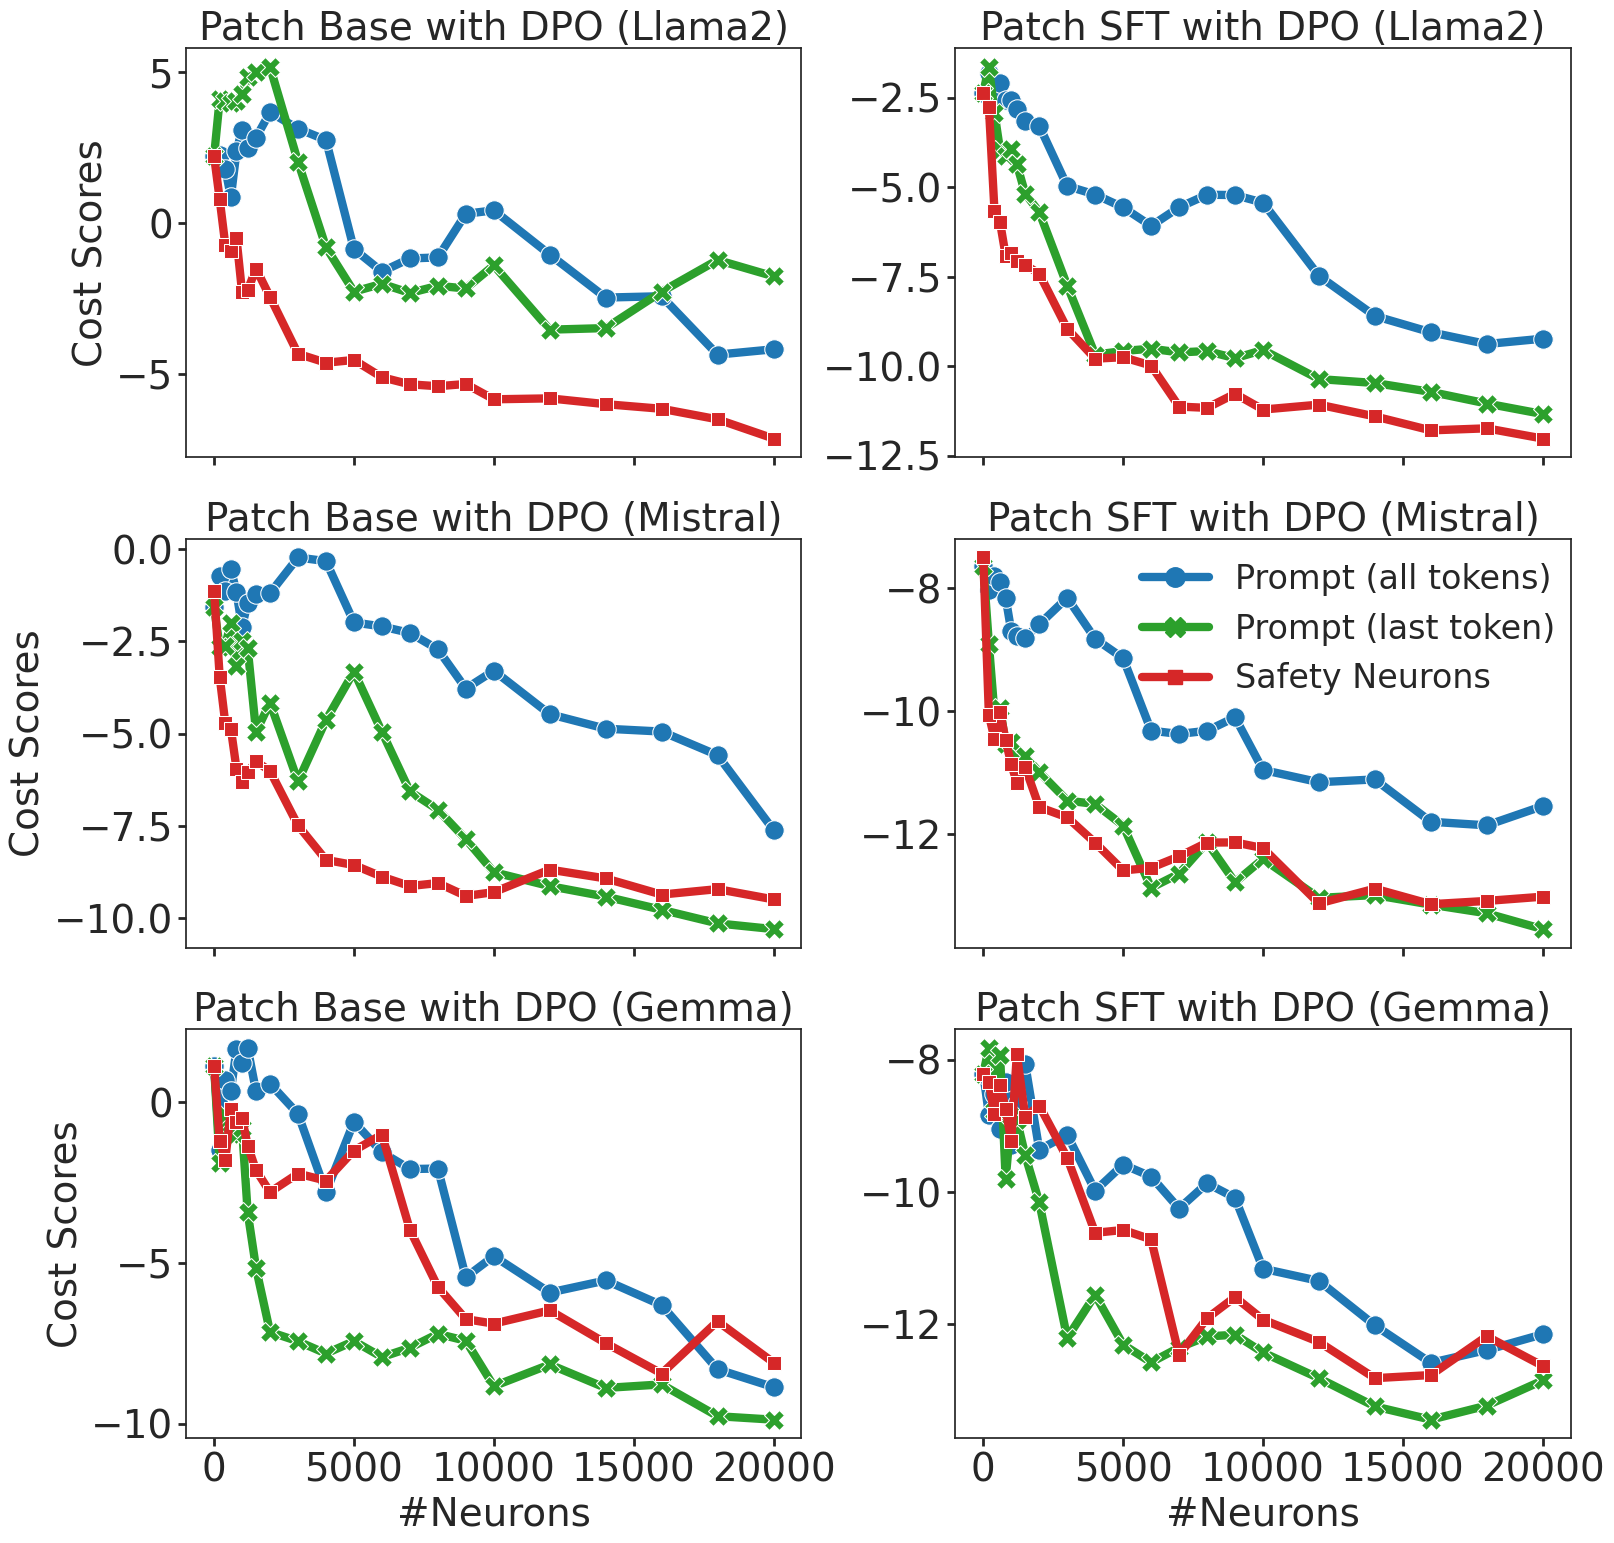

In [94]:
fontsize = 28
sns.set_theme(style='ticks')
palettes = sns.color_palette("tab10")
palette = [palettes[0], palettes[2], palettes[3]]
model_names = ['Llama2', 'Mistral', 'Gemma']
patch_names = ['Patch Base with DPO', 'Patch SFT with DPO']
g = sns.relplot(x='topk', y='cost', data=df, hue='Token Position', style='Token Position', row='Model', col='peft', kind='line', aspect=1.5, facet_kws=dict(sharey=False), linewidth=6, markers=True, markersize=14, dashes=False, palette=palette)
g.set_axis_labels(x_var='#Neurons', y_var='Cost Scores', fontsize=fontsize)
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=fontsize, width=2)  # Adjust ticks appearance
for i in range(3):
    for j in range(2):
        g.axes[i, j].set_title(f'{patch_names[j]} ({model_names[i]})', fontsize=fontsize)
g.fig.subplots_adjust(hspace=0.2, wspace=0.25)
# Define a custom font
# custom_font = font_manager.FontProperties(style='normal', weight=700, size=18)
# g._legend.get_title().set_fontproperties(custom_font)
g.legend.set_title(None)
sns.move_legend(g, 'upper right', bbox_to_anchor=(0.88,0.65), fontsize=24, frameon=False)
for ax in g.axes.flat:
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
plt.savefig('./fig/different_positions.pdf', dpi=300, format='pdf', bbox_inches="tight")

#### Std vs rank

In [ ]:
activations = []
# model_name = 'Llama-2-7b-hf_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff'
# model_name = 'Llama-2-7b-hf_sharegpt_ia3_ff_1'
model_name = 'Llama-2-7b-hf'
filenames = ['hh_harmless_prompt_last_token', 'hh_helpful_prompt_last_token']
for filename in filenames:
    activation = torch.load(f'/data1/cjh/Alignment/output/activations/{model_name}/{filename}.pt')
    activations.append(activation)

_, index, *_ = torch.load(f'/data1/cjh/Alignment/hooked_llama/neuron_activation/{model_name}_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_sft_vs_dpo_on_hh_harmless_sft_completion.pt')

In [ ]:
activation_std = torch.concat(activations, 0).std(0)

In [ ]:
n_groups = 4
topk = 20000
df_dict = {'std': [], 'ranks': []}
df_dict['ranks'] += (np.arange(topk) // (topk // n_groups)).tolist()
df_dict['std'] += [activation_std[layer, neuron].item() for layer, neuron in index[:topk]]
df = pd.DataFrame(data=df_dict)

In [ ]:
g = sns.violinplot(x='ranks', y='std', data=df)
g.set_xlabel('Top K Neurons', fontsize=18, fontweight=500)
g.set_ylabel('Activation Std', fontsize=18, fontweight=500)
g.set_xticklabels(range(0, topk+1, topk//n_groups), fontsize=18, fontweight=500)
# g.set_ylim(-0.18, 1.18)
g.set_yticklabels(g.get_yticklabels(), fontsize=18, fontweight=500)
plt.savefig('./fig/std_distribution.pdf', dpi=600, format='pdf', bbox_inches="tight")

### Safety Eval

/tmp/ipykernel_295664/3293184252.py:30: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  g = sns.catplot(


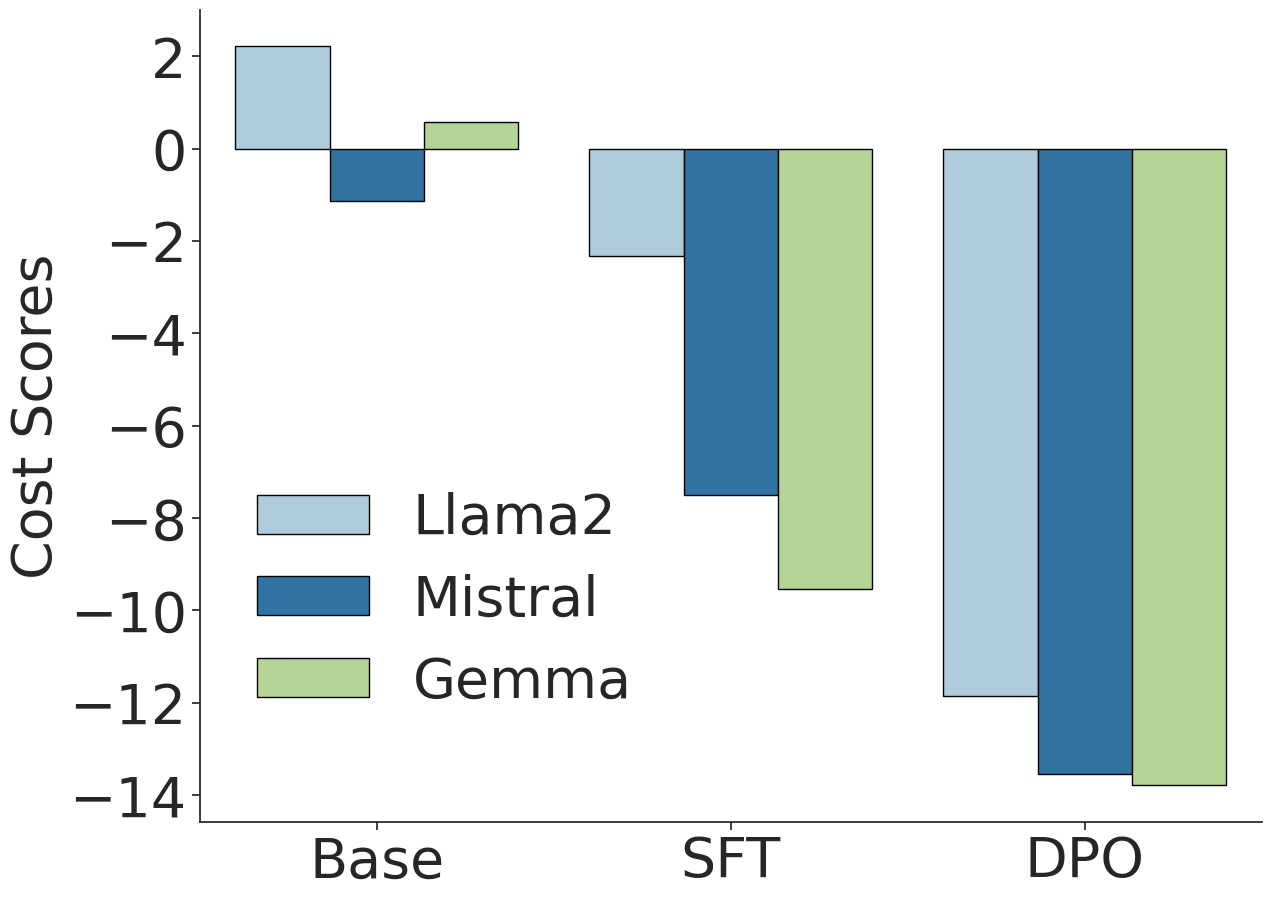

In [119]:
# Create the DataFrame from the provided table data
data = {
    'Method': ['Base', 'SFT', 'DPO'],
    'Llama2_mean': [2.21, -2.33, -11.85],
    'Llama2_std': [11.81, 15.26, 5.27],
    'Mistral_mean': [-1.13, -7.50, -13.55],
    'Mistral_std': [13.35, 11.58, 5.30],
    'Gemma_mean': [0.58, -9.54, -13.78],
    'Gemma_std': [12.82, 10.50, 5.45]
}
df = pd.DataFrame(data)
# Melt the DataFrame to long format for Seaborn
df_mean = df.melt(id_vars='Method', 
                  value_vars=['Llama2_mean', 'Mistral_mean', 'Gemma_mean'], 
                  var_name='Model', value_name='Mean')

df_std = df.melt(id_vars='Method', 
                 value_vars=['Llama2_std', 'Mistral_std', 'Gemma_std'], 
                 var_name='Model', value_name='Std')

# Clean up the model names
df_mean['Model'] = df_mean['Model'].str.replace('_mean', '')
df_std['Model'] = df_std['Model'].str.replace('_std', '')

# Merge the mean and std DataFrames
df_melted = pd.merge(df_mean, df_std, on=['Method', 'Model'])

sns.set_theme(style="ticks")
fontsize = 40
g = sns.catplot(
    x='Method', y='Mean', hue='Model', data=df_melted, kind='bar', 
    palette=custom_palette, capsize=0.1, aspect=1.3, height=9, edgecolor='black'
)
# Customizing the plot
plt.xlabel(None)
plt.ylabel('Cost Scores', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.08,0.5), fontsize=fontsize, frameon=False, ncol=1)
g.legend.set_title(None)
plt.savefig('./fig/cost_scores.pdf', dpi=300, format='pdf', bbox_inches="tight")


In [95]:
df = pd.read_json('/home/cjh/Academics/Alignment-Low-Rank-Analysis/results/safety_guard.json')

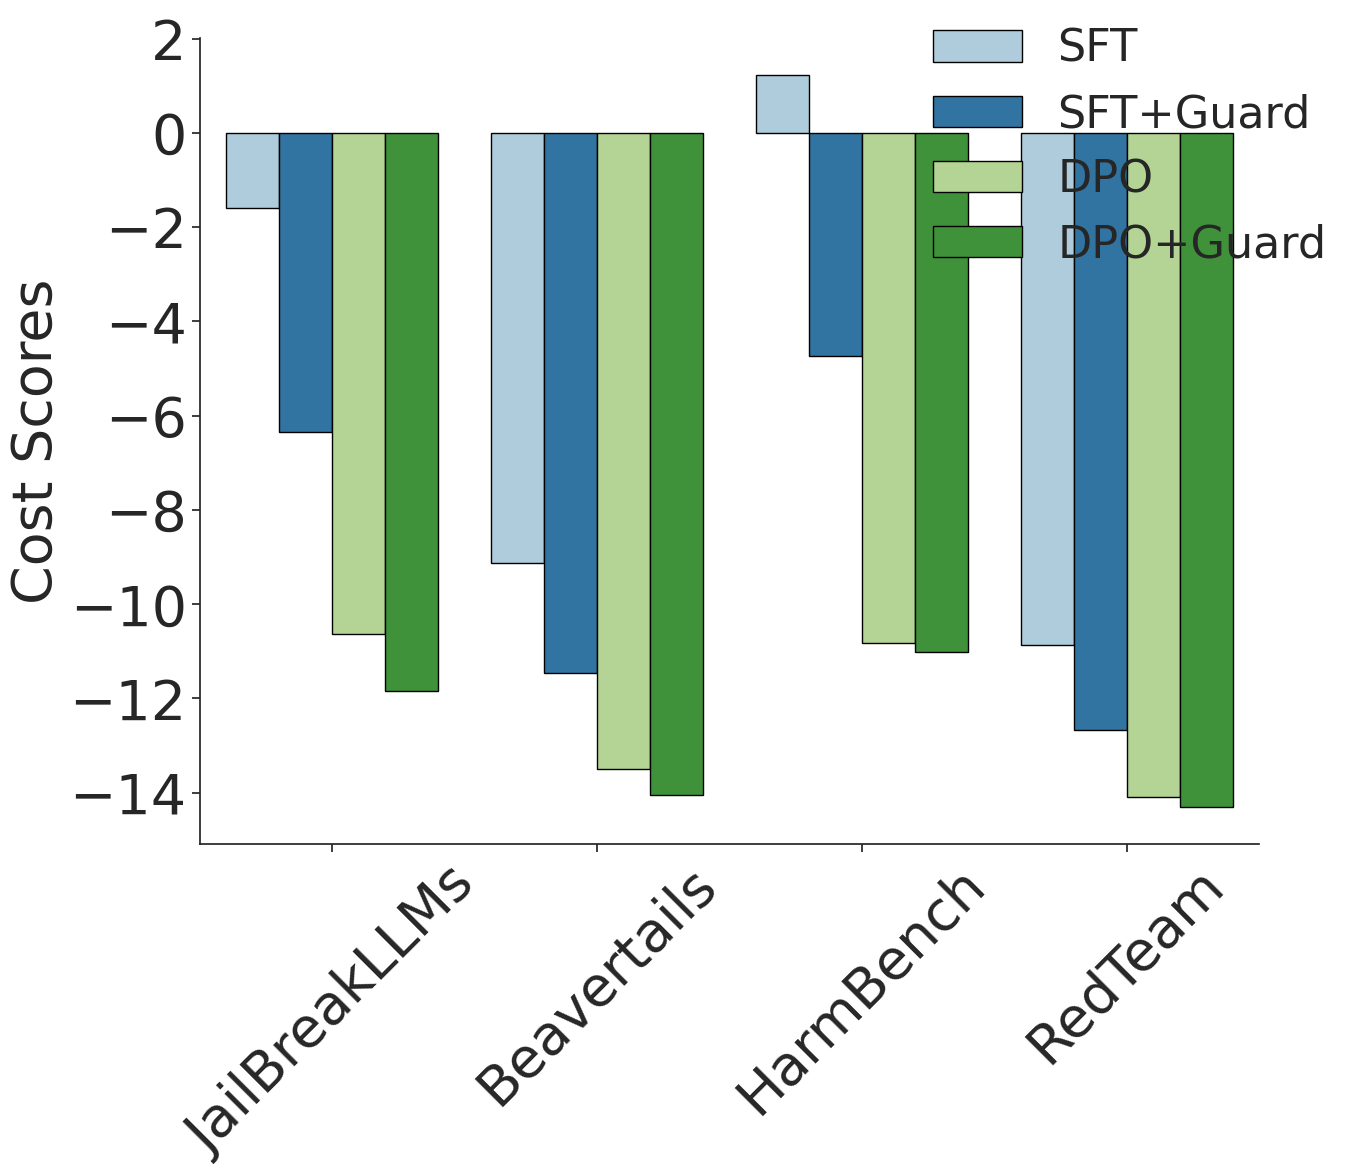

In [96]:
sns.set_theme(style="ticks")
fontsize = 40
models = df['Model'].unique()
titles = ['JailBreakLLMs', 'Beavertails', 'HarmBench', 'RedTeam']
# Define a custom color palette for the desired hue order
custom_palette = sns.color_palette("Paired", 4)
# Plot the bar plot with error bars
g = sns.catplot(
    x='Dataset', y='mean', hue='Type', data=df[df['Model']==models[1]], kind='bar', 
    palette=custom_palette, capsize=0.1, aspect=1.3, height=9, edgecolor='black'
)
# Customizing the plot
plt.xlabel(None)
plt.ylabel('Cost Scores', fontdict={'weight': 500, 'size': fontsize})
plt.xticks(fontsize=fontsize, weight=500, rotation=45)
plt.yticks(fontsize=fontsize, weight=500)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.6,1.03), frameon=False, prop={'size': 32, 'weight': 500}, ncol=1)
g.legend.set_title(None)
# Set xtick labels to custom titles
g.set_xticklabels(titles)
plt.savefig('./fig/safety_guard_mistral.pdf', dpi=300, format='pdf', bbox_inches="tight")

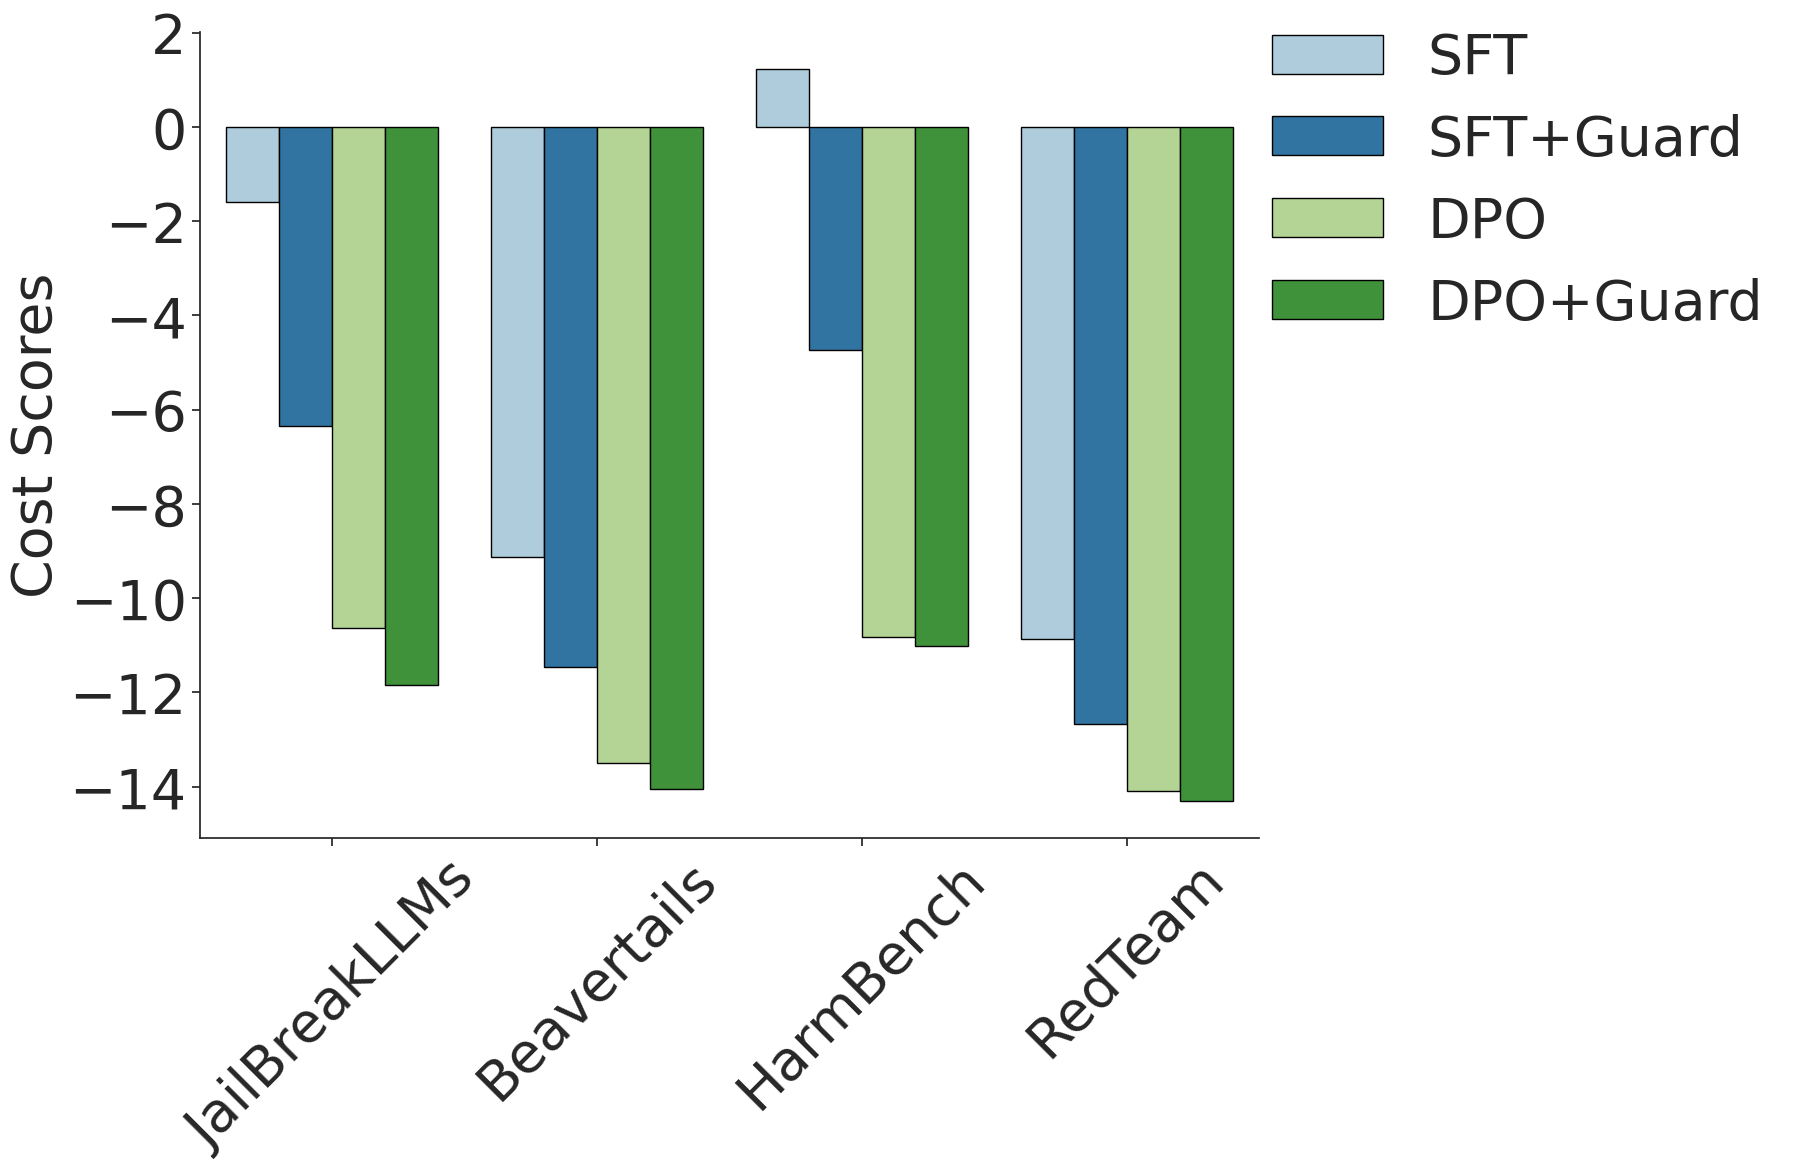

In [110]:
g = sns.catplot(
    x='Dataset', y='mean', hue='Type', data=df[df['Model']==models[1]], kind='bar', 
    palette=custom_palette, capsize=0.1, aspect=1.3, height=9, edgecolor='black'
)
# Customizing the plot
plt.xlabel(None)
plt.ylabel('Cost Scores', fontsize=fontsize)
plt.xticks(fontsize=fontsize, rotation=45)
plt.yticks(fontsize=fontsize)
sns.move_legend(g, 'upper left', bbox_to_anchor=(0.85,1.03), fontsize=fontsize, frameon=False, ncol=1)
g.legend.set_title(None)
# Set xtick labels to custom titles
g.set_xticklabels(titles)
plt.savefig('./fig/safety_guard_gemma.pdf', dpi=300, format='pdf', bbox_inches="tight")

### Activation Visualization

In [73]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go

In [40]:
def get_activation(activation: torch.Tensor, index: torch.Tensor):
    # Extract the relevant dimensions from indices
    index_dim1 = index[:, 0]
    index_dim2 = index[:, 1]
    # Create an expanded version of the batch indices
    batch_indices = torch.arange(activation.shape[0]).unsqueeze(1).expand(activation.shape[0], index.shape[0])
    return activation[batch_indices, index_dim1, index_dim2]

In [3]:
activations = []
model_name = 'Llama-2-7b-hf'
filenames = ['hh_harmless_prompt_last_token', 'hh_helpful_prompt_last_token']
for filename in filenames:
    activation = torch.load(f'/data1/cjh/Alignment/output/activations/{model_name}/{filename}.pt')
    activations.append(activation)

In [10]:
_, index, *_ = torch.load('/data1/cjh/Alignment/hooked_llama/neuron_activation/Llama-2-7b-hf_sharegpt_ia3_ff_1_hh_harmless_dpo_ia3_ff_sft_vs_dpo_on_hh_harmless_sft_completion.pt')

In [76]:
topk_index = index[:3]

In [77]:
harmless_activations = get_activation(activations[0], topk_index)
helpful_activations = get_activation(activations[1], topk_index)
labels = [0] * harmless_activations.shape[0] + [1] * helpful_activations.shape[0]

In [80]:
activations, labels = torch.load('/data1/cjh/Alignment/output/activations/harmless_prediction/beavertails_-1_Llama-2-7b-hf_sharegpt_ia3_ff_1_top1500.pt')

In [85]:
act_pca = TSNE(n_components=3).fit_transform(activations)

In [86]:
# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=act_pca[:, 0], y=act_pca[:, 1], z=act_pca[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=labels,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# Customize the layout
fig.update_layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
